In [1]:
# BLOCO 1 - Importing Libraries

import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
import librosa
import librosa.display
import requests
# Instala√ß√£o de bibliotecas necess√°rias (mantido do seu original)
!pip install kaggle tensorflow tensorflow_hub librosa matplotlib

# Instala√ß√£o de bibliotecas necess√°rias
!pip install kaggle tensorflow tensorflow_hub librosa matplotlib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.optimizers import Adam


In [2]:
# BLOCO 2 - CRIA DIRET√ìRIOS E BAIXA JSON

# 1. Cria o diret√≥rio /content/kaggle
os.makedirs('/content/kaggle', exist_ok=True)
print("Diret√≥rio /content/kaggle criado com sucesso.")

# 2. Continua com a cria√ß√£o do diret√≥rio de configura√ß√£o padr√£o do Kaggle (necess√°rio)
# Se voc√™ ainda for usar a API do Kaggle para baixar dados, este diret√≥rio √© essencial.
os.makedirs('/root/.kaggle', exist_ok=True)
print("Diret√≥rio /root/.kaggle criado para a chave de API.")

file_id = "1drlyKgvfvFaE69SzowRjcF5KK14jaroQ"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
dest_path = "/content/kaggle/kaggle.json"

response = requests.get(url)
if response.status_code == 200:
    with open(dest_path, "wb") as f:
        f.write(response.content)
    print("Arquivo JSON baixado com sucesso.")
else:
    print("Erro ao baixar o arquivo:", response.status_code)

!cp "{dest_path}" "/root/.kaggle"

# 3. Garante permiss√µes (para o arquivo que estar√° em /root/.kaggle/kaggle.json)
# Este comando s√≥ ter√° efeito *depois* que o arquivo kaggle.json for copiado para l√°.
!chmod 600 /content/kaggle/kaggle.json
!chmod 600 /root/.kaggle

# 1. Cria o diret√≥rio /content/kaggle
os.makedirs('/content/musical', exist_ok=True)
print("Diret√≥rio /content/musical criado com sucesso.")

# 2. Garante permiss√µes (para o arquivo que estar√° em /root/musical)
# Este comando s√≥ ter√° efeito *depois* que o arquivo kaggle.json for copiado para l√°.
!chmod 600 /content/musical


Diret√≥rio /content/kaggle criado com sucesso.
Diret√≥rio /root/.kaggle criado para a chave de API.
Arquivo JSON baixado com sucesso.
Diret√≥rio /content/musical criado com sucesso.


In [3]:
# BLOCO 3 - FAZ DOWNLOAD E DESCOMPACTA O ARQUIVO DO DATASET

import os

DATA_DIR = '/content/musical/'
DATASET_SLUG = 'soumendraprasad/musical-instruments-sound-dataset'
ZIP_FILE = os.path.join(DATA_DIR, 'musical-instruments-sound-dataset.zip')

# Baixa o dataset do Kaggle para o diret√≥rio
# Use 'f-string' para que a vari√°vel {DATASET_SLUG} seja impressa corretamente
print(f'Baixando dataset {DATASET_SLUG}...')
!kaggle datasets download -d {DATASET_SLUG} -p {DATA_DIR}

# Descompacta o arquivo ZIP
print('Descompactando arquivos...')
# O '-q' √© para modo quieto
!unzip -q {ZIP_FILE} -d {DATA_DIR}

print('Download e descompacta√ß√£o conclu√≠dos.')

Baixando dataset soumendraprasad/musical-instruments-sound-dataset...
Dataset URL: https://www.kaggle.com/datasets/soumendraprasad/musical-instruments-sound-dataset
License(s): CC0-1.0
100% 5.38G/5.40G [01:23<00:00, 246MB/s]
100% 5.40G/5.40G [01:23<00:00, 69.7MB/s]
Descompactando arquivos...
Download e descompacta√ß√£o conclu√≠dos.


Class
Sound_Guitar    700
Sound_Drum      700
Sound_Violin    700
Sound_Piano     529
Name: count, dtype: int64


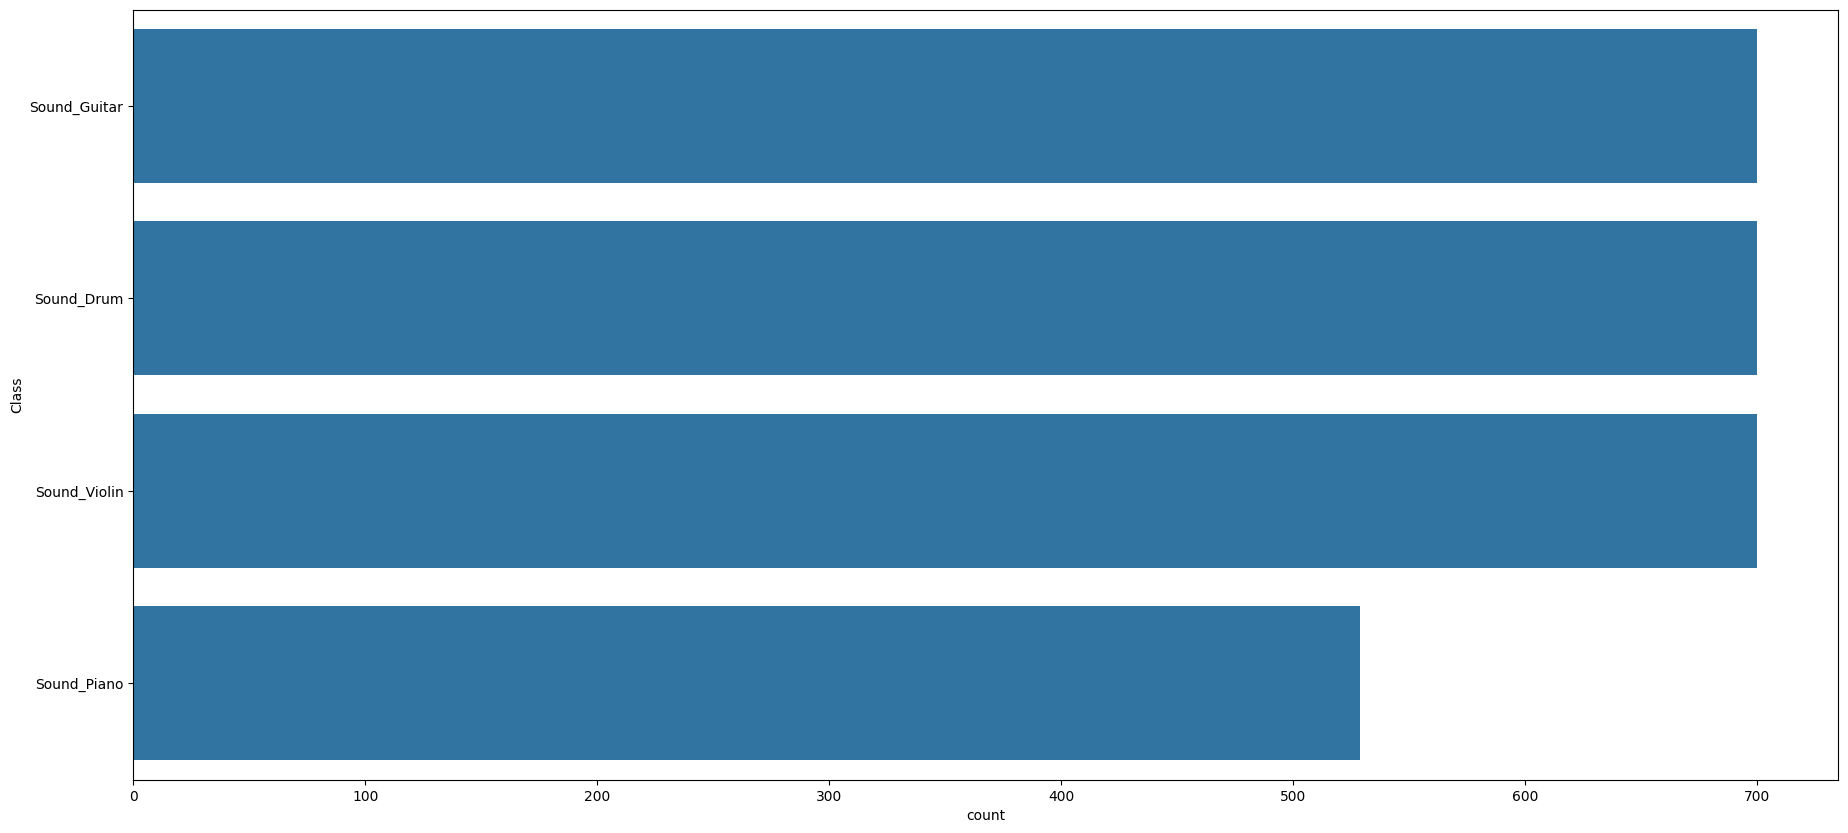

Class
Sound_Guiatr    20
Sound_Drum      20
Sound_Violin    20
Sound_Piano     20
Name: count, dtype: int64


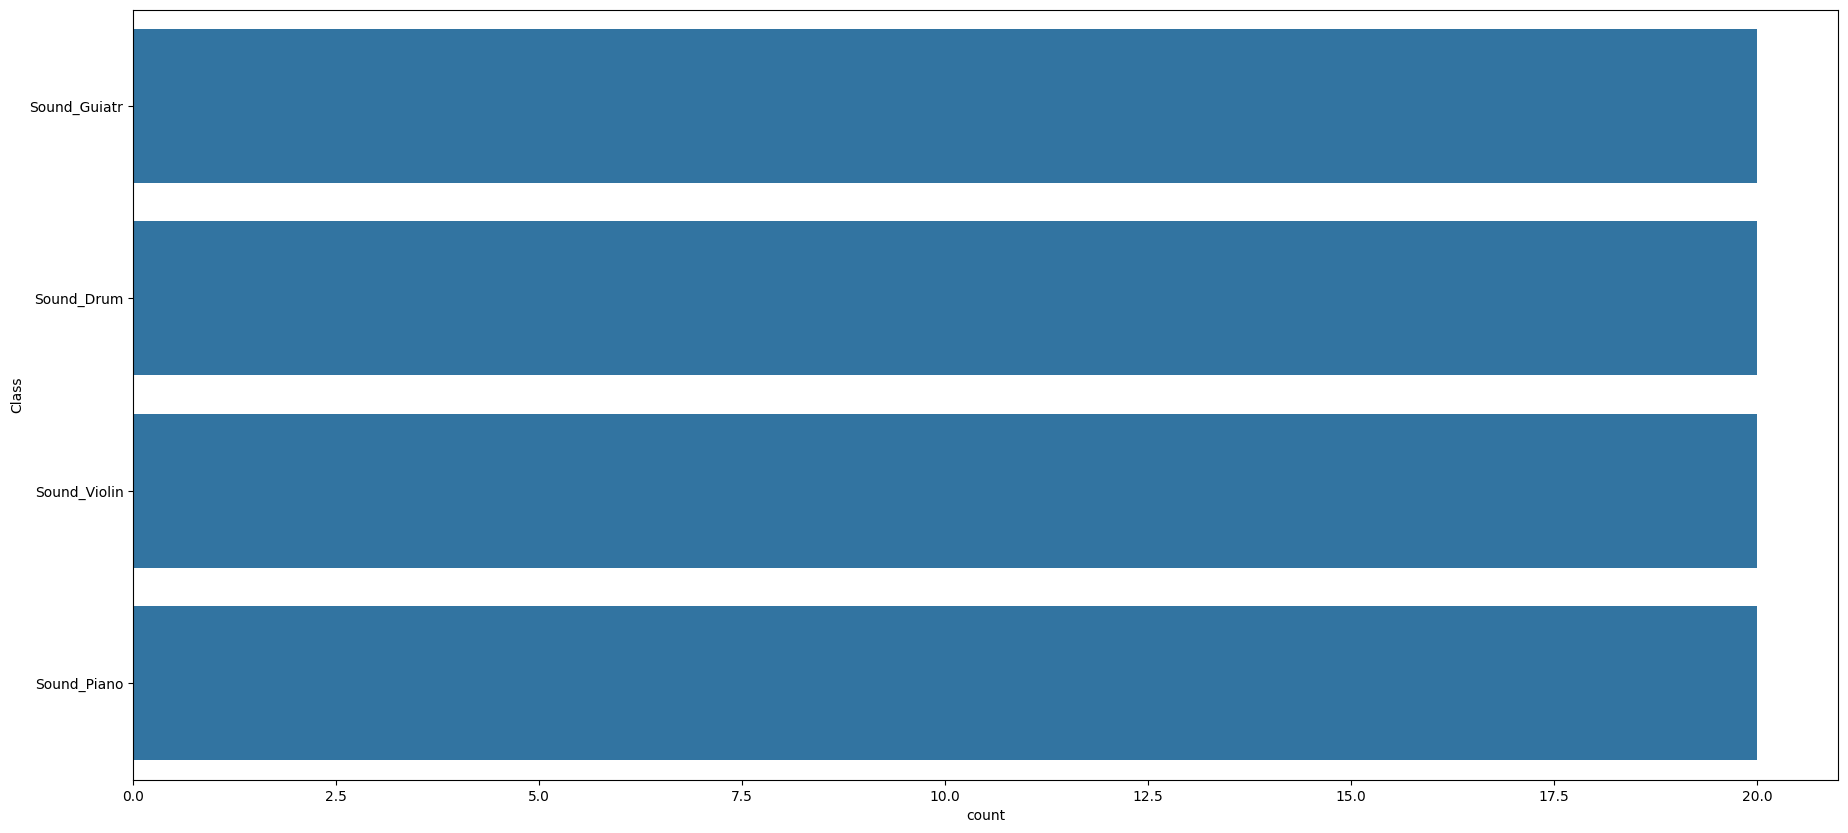

In [4]:
# BLOCO 4 - VALIDA CSV - ABRE E VE O CONTEUDO
# Exploring csv Files

df=pd.read_csv("/content/musical/Metadata_Train.csv")
df2=pd.read_csv("/content/musical/Metadata_Test.csv")

df

# Visualizing Tag column

print(df['Class'].value_counts())
plt.figure(figsize=(22,10))
sns.countplot(df['Class'])
plt.xticks(rotation=0)

plt.show()

print(df2['Class'].value_counts())
plt.figure(figsize=(22,10))
sns.countplot(df2['Class'])
plt.xticks(rotation=0)

plt.show()

Feature_extractor definida para 120 features (40 MFCCs + Delta + Delta-Delta).
Iniciando extra√ß√£o de features e dura√ß√£o (120 dimens√µes)...
Tempo total de processamento: 334.21 segundos.
Total de arquivos com METADADOS e DURA√á√ÉO v√°lidos no DataFrame final: 3329
Total de FEATURES (X) extra√≠das com sucesso: 3329 amostras de 120 dimens√µes.
Total de R√ìTULOS (y) extra√≠dos com sucesso: 3329 r√≥tulos.


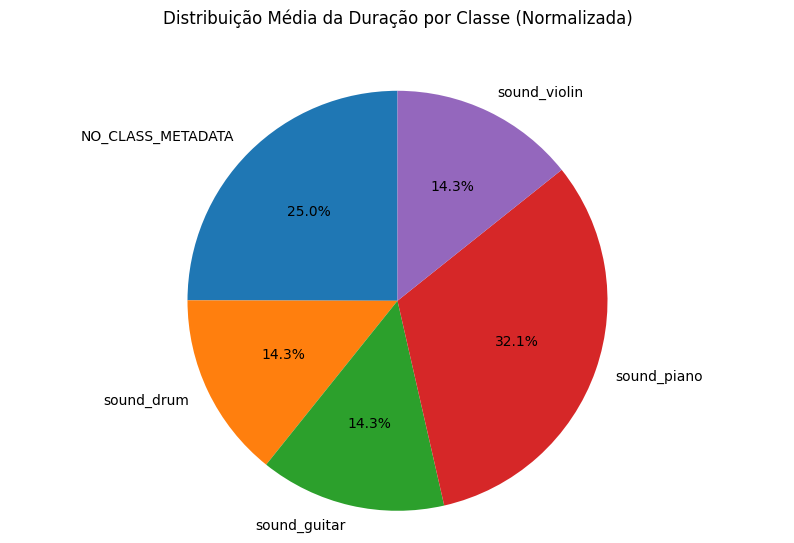

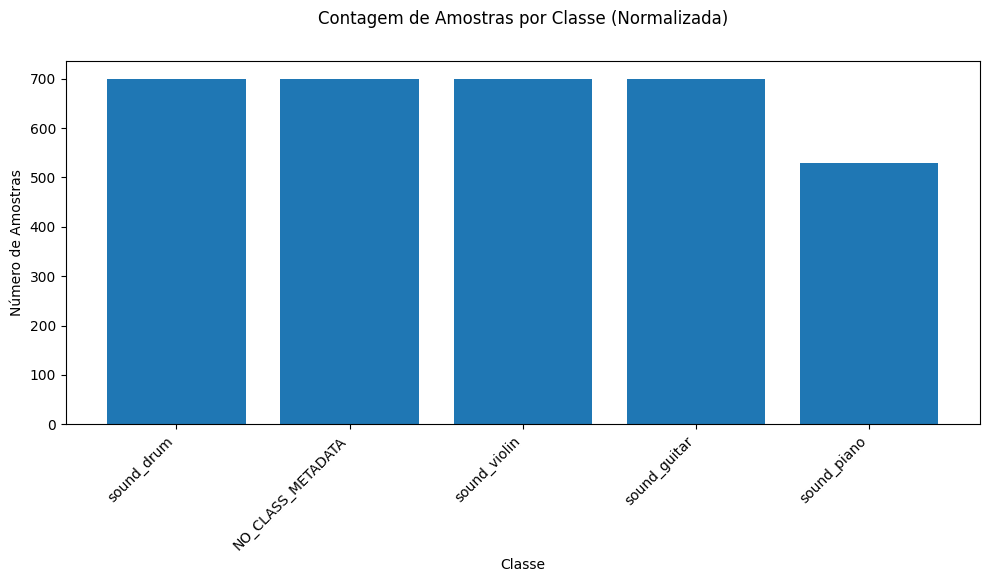


TABELA DE RESUMO E ESTAT√çSTICAS INICIAIS (Classes Normalizadas)
                   count  avg_length  min_length  max_length
Class                                                       
NO_CLASS_METADATA    700   24.995616    4.014000      60.000
sound_drum           700   14.304025    1.058639     128.064
sound_guitar         700   14.341907    1.444762      82.000
sound_violin         700   14.304025    1.058639     128.064
sound_piano          529   32.187041    2.328000     124.440

DataFrame de Metadados Processado salvo como 'df_processed.csv' para o Bloco 6.
Arrays X (Features) e y (R√≥tulos) salvos em 'features_X.npy' e 'labels_y.npy' para o Bloco 6.


In [29]:
# BLOCO 5 - CARREGA METADATA DOS ARQUIVOS, MESCLA, PROCESSA, CALCULA, ANALISA, VISUALIZA E GERA TABELA RESUMO

import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import time

# ==============================================================================
# 1. DEFINI√á√ÉO DE CONSTANTES
# ==============================================================================
DIRETORIO_AUDIO = '/content/musical/Train_submission/Train_submission/'
ARQUIVO_CSV = "/content/musical/Metadata_Train.csv"
METADADOS_PATH_OUT = 'df_processed.csv'
FEATURES_PATH_OUT = 'features_X.npy'
LABELS_PATH_OUT = 'labels_y.npy'

# CONSTANTE PARA NORMALIZA√á√ÉO DE VALORES DESCONHECIDOS
CLASSE_DESCONHECIDA = 'NO_CLASS_METADATA'

# CONSTANTES PARA EXTRA√á√ÉO DE FEATURES
N_MFCC = 40
MAX_PAD_LEN = 40
# ==============================================================================
# 2. FUN√á√ÉO FEATURE EXTRACTOR (MFCCs, Delta, Delta-Delta)
# ==============================================================================

def Feature_extractor(filename, n_mfcc=N_MFCC, max_pad_len=MAX_PAD_LEN):
    """Extrai 120 features (MFCCs, Delta, Delta-Delta) de um arquivo de √°udio."""
    try:
        # 1. Carrega o arquivo de √°udio (sr=None para usar a taxa original e manter flexibilidade)
        audio, sample_rate = librosa.load(filename, res_type='kaiser_fast', sr=None)

        # 2. Calcula MFCCs (40 coeficientes)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

        # 3. Calcula Delta (Derivada de 1¬™ ordem)
        mfccs_delta = librosa.feature.delta(mfccs)

        # 4. Calcula Delta-Delta (Derivada de 2¬™ ordem)
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

        # 5. Padroniza o comprimento de todos (MFCC, Delta, Delta-Delta)
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            mfccs_delta = np.pad(mfccs_delta, pad_width=((0, 0), (0, pad_width)), mode='constant')
            mfccs_delta2 = np.pad(mfccs_delta2, pad_width=((0, 0), (0, pad_width)), mode='constant')
        elif pad_width < 0:
            mfccs = mfccs[:, :max_pad_len]
            mfccs_delta = mfccs_delta[:, :max_pad_len]
            mfccs_delta2 = mfccs_delta2[:, :max_pad_len]

        # 6. Calcula a m√©dia temporal de cada coeficiente/delta/delta-delta
        feature = np.concatenate((np.mean(mfccs.T, axis=0), np.mean(mfccs_delta.T, axis=0), np.mean(mfccs_delta2.T, axis=0)))

        # Retorna feature E a dura√ß√£o (obtida de librosa.load) para uso posterior
        duration = librosa.get_duration(y=audio, sr=sample_rate)

        return feature, duration

    except Exception as e:
        # print(f"Erro ao processar o arquivo {filename}: {e}")
        return None, None

print(f"Feature_extractor definida para {N_MFCC*3} features ({N_MFCC} MFCCs + Delta + Delta-Delta).")
print("="*50)

# ==============================================================================
# 3. CARREGAMENTO INICIAL DO CSV E NORMALIZA√á√ÉO DE COLUNA
# ==============================================================================
df = pd.read_csv(ARQUIVO_CSV)

# Normaliza√ß√£o
df.columns = [col.strip() for col in df.columns]
df.rename(columns={'FileName': 'FileName'}, inplace=True)

if 'Class' in df.columns:
    df['Class'] = df['Class'].str.lower()
    df['Class'] = df['Class'].str.strip()

# ==============================================================================
# 4. LISTAGEM DE ARQUIVOS E MESCLAGEM DOS DATAFRAMES
# ==============================================================================
arquivos_no_diretorio = [f for f in os.listdir(DIRETORIO_AUDIO) if f.endswith(('.wav', '.mp3', '.ogg', '.flac'))]

df_diretorio = pd.DataFrame({'FileName': arquivos_no_diretorio})

df_processed = pd.merge(df_diretorio, df, on='FileName', how='outer')

df_processed['Class'].fillna(CLASSE_DESCONHECIDA, inplace=True)

# Inicializa as colunas (length n√£o precisa ser inicializada com NaN aqui)
df_processed['length'] = np.nan

# ==============================================================================
# 5. PROCESSAMENTO: EXTRAI FEATURES E DURA√á√ÉO SIMULTANEAMENTE
# ==============================================================================

all_features = []
all_labels = []
processed_filenames_features = []
processed_lengths = [] # Novo: Coleta as dura√ß√µes junto com as features

erros_processamento = 0

print("Iniciando extra√ß√£o de features e dura√ß√£o (120 dimens√µes)...")
start_time = time.time()

for idx, row in df_processed.iterrows():
    f = row['FileName']
    caminho_completo = os.path.join(DIRETORIO_AUDIO, f)

    # Tenta extrair features e dura√ß√£o em uma √∫nica chamada
    if os.path.exists(caminho_completo):
        features, duration = Feature_extractor(caminho_completo)

        if features is not None:
            all_features.append(features)
            all_labels.append(row['Class'])
            processed_filenames_features.append(f)
            processed_lengths.append(duration) # Coleta a dura√ß√£o
        else:
            erros_processamento += 1

end_time = time.time()
print(f"Tempo total de processamento: {end_time - start_time:.2f} segundos.")

# 5.1. Normaliza√ß√£o de Dados: Cria X e y e Filtra o DataFrame de Metadados
X = np.array(all_features)
y = np.array(all_labels)

# Filtra o DataFrame de metadados para ter APENAS os arquivos que geraram features v√°lidas
df_processed = df_processed[df_processed['FileName'].isin(processed_filenames_features)].copy()

# Adiciona a coluna 'length' ao DataFrame final (sem usar .loc em loop)
df_processed['length'] = processed_lengths

if erros_processamento > 0:
    print(f"ATEN√á√ÉO: {erros_processamento} arquivos foram removidos do conjunto de dados final devido a falhas de leitura/extra√ß√£o.")

print(f"Total de arquivos com METADADOS e DURA√á√ÉO v√°lidos no DataFrame final: {len(df_processed)}")
print(f"Total de FEATURES (X) extra√≠das com sucesso: {X.shape[0]} amostras de {X.shape[1]} dimens√µes.")
print(f"Total de R√ìTULOS (y) extra√≠dos com sucesso: {y.shape[0]} r√≥tulos.")


# ==============================================================================
# 6. RECRIA√á√ÉO DA DISTRIBUI√á√ÉO E PLOTAGEM (Baseado na DURA√á√ÉO)
# ==============================================================================
# Verifica se o DataFrame n√£o est√° vazio antes de plotar
if not df_processed.empty:
    class_dist = df_processed.groupby(['Class'])['length'].mean()

    # Plotagem da M√©dia da Dura√ß√£o
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title('Distribui√ß√£o M√©dia da Dura√ß√£o por Classe (Normalizada)', y=1.08)
    ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
            shadow=False, startangle=90)
    ax.axis('equal')
    plt.show()

    # Plotagem da Contagem de Amostras
    class_count = df_processed['Class'].value_counts()
    fig_count, ax_count = plt.subplots(figsize=(10, 6))
    ax_count.set_title('Contagem de Amostras por Classe (Normalizada)', y=1.08)
    ax_count.bar(class_count.index, class_count.values)
    ax_count.set_ylabel('N√∫mero de Amostras')
    ax_count.set_xlabel('Classe')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nAVISO: DataFrame de Metadados est√° vazio. Gr√°ficos de distribui√ß√£o e resumo n√£o foram gerados.")


# ==============================================================================
# 7. GERA√á√ÉO DA TABELA DE RESUMO
# ==============================================================================

print("\n" + "="*50)
print("TABELA DE RESUMO E ESTAT√çSTICAS INICIAIS (Classes Normalizadas)")
print("="*50)

if not df_processed.empty:
    # Resumo de classes normalizadas
    summary = df_processed.groupby('Class').agg(
        count=('FileName', 'size'),
        avg_length=('length', 'mean'),
        min_length=('length', 'min'),
        max_length=('length', 'max')
    )
    print(summary.sort_values(by='count', ascending=False))
else:
    print("DataFrame est√° vazio. Nenhuma tabela de resumo gerada.")

# ==============================================================================
# 8. SALVAR O DATAFRAME PROCESSADO E OS ARQUIVOS DE FEATURES (X e y)
# ==============================================================================
# Salva os Metadados (apenas colunas necess√°rias para o pr√≥ximo bloco)
df_to_save = df_processed[['FileName', 'Class', 'length']].copy()

try:
    df_to_save.to_csv(METADADOS_PATH_OUT, index=False)
    print(f"\nDataFrame de Metadados Processado salvo como '{METADADOS_PATH_OUT}' para o Bloco 6.")
except Exception as e:
    print(f"\nAVISO: N√£o foi poss√≠vel salvar o arquivo '{METADADOS_PATH_OUT}': {e}")

# Salva os Features e R√≥tulos (X e y) em formato NumPy
try:
    np.save(FEATURES_PATH_OUT, X)
    np.save(LABELS_PATH_OUT, y)
    print(f"Arrays X (Features) e y (R√≥tulos) salvos em '{FEATURES_PATH_OUT}' e '{LABELS_PATH_OUT}' para o Bloco 6.")
except Exception as e:
    print(f"AVISO: N√£o foi poss√≠vel salvar os arrays de Features/R√≥tulos: {e}")

print("="*50)

# Fim do Script

In [33]:
# BLOCO 6 - PROCESSAMENTO DE AUDIO / EXTRA√á√ÉO DE CARACTERISTICAS / PLOTA FFTS

import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import sys

# üî¥ NOVAS DEPEND√äNCIAS PARA EXTRA√á√ÉO DE FEATURES E ML
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
# ‚ùó Se 'to_categorical' vier do Keras/TensorFlow, importe-a
from keras.utils import to_categorical
# OU
# from tensorflow.keras.utils import to_categorical

# --------------------------------------------------------------------------
# VARI√ÅVEIS DO AMBIENTE E CARREGAMENTO DE DADOS (NORMALIZA√á√ÉO ESTRUTURAL)
# --------------------------------------------------------------------------

METADADOS_PATH = 'df_processed.csv'
DIRETORIO_AUDIO = '/content/musical/Train_submission/Train_submission/'

# NOVO PAR√ÇMETRO DE DURA√á√ÉO PADRONIZADA (em segundos)
MAX_DURATION_SECONDS = 3.0 # Definir uma dura√ß√£o m√°xima uniforme (3 segundos)
# NOVO PAR√ÇMETRO DE DURA√á√ÉO M√çNIMA (em segundos)
MIN_DURATION_SECONDS = 0.5

# Carregamento do df_processed...
try:
    df = pd.read_csv(METADADOS_PATH)
    print(f"DataFrame 'df' carregado com {len(df)} entradas. (Classes j√° normalizadas pelo Bloco 5)")
except FileNotFoundError:
    print(f"ERRO CR√çTICO: O arquivo de metadados '{METADADOS_PATH}' n√£o foi encontrado.")
    sys.exit(1)
except Exception as e:
    print(f"ERRO ao carregar o DataFrame de metadados: {e}")
    sys.exit(1)

if not df.empty and 'Class' in df.columns:
    classes = list(np.unique(df.Class))
    print(f"Classes encontradas: {classes}")
else:
    print("ERRO CR√çTICO: DataFrame carregado, mas vazio ou coluna 'Class' ausente.")
    sys.exit(1)

# --------------------------------------------------------------------------
# FUN√á√ïES DE FEATURE EXTRACTION (COM NORMALIZA√á√ÉO DE SINAL)
# --------------------------------------------------------------------------

# Calculate FFT
def calc_fft(y, sr):
    n = len(y)
    if n == 0:
        return (np.array([0]), np.array([0]))

    # NORMALIZA√á√ÉO DE FFT:
    Y = abs(np.fft.rfft(y)/n)
    Y_norm = Y / np.sum(Y) if np.sum(Y) > 0 else Y # Normaliza por somat√≥ria

    freq = np.fft.rfftfreq(n, d=1/sr)
    return (Y_norm, freq)

# Valuable Info In Sample (Envelope)
def Envelope(y, rate, threshold):
    y_series = pd.Series(y).apply(np.abs)
    window_size = max(1, int(rate/4))
    y_mean = y_series.rolling(window=window_size, min_periods=1, center=True).mean()
    mask = (y_mean > threshold).values
    return mask

# Fun√ß√£o para carregar, normalizar o volume, remover sil√™ncio e padronizar a dura√ß√£o
def process_audio_file(filepath, max_duration=MAX_DURATION_SECONDS, min_duration=MIN_DURATION_SECONDS, threshold=0.005):
    try:
        # Carrega o √°udio
        y, sr = librosa.load(filepath, sr=None)

        # 1. NORMALIZA√á√ÉO DE VOLUME (Amplitude Scaling)
        y = librosa.util.normalize(y)

        # 2. NORMALIZA√á√ÉO DE DURA√á√ÉO (Remo√ß√£o de Sil√™ncio - Envelope)
        mask = Envelope(y, sr, threshold=threshold)
        y_env = y[mask]

        # Checagem de dura√ß√£o m√≠nima
        if len(y_env) / sr < min_duration:
            pass # Continua, usando o que sobrou

        # 3. NORMALIZA√á√ÉO DE DURA√á√ÉO (Padding/Clipping)
        max_samples = int(max_duration * sr)

        if len(y_env) > max_samples:
            # Clipping: Corta o √°udio se for muito longo
            y_final = y_env[:max_samples]
        elif len(y_env) < max_samples:
            # Padding: Adiciona zeros no final se for muito curto
            y_final = librosa.util.pad_center(y_env, size=max_samples, axis=-1)
        else:
            y_final = y_env

        return y_final, sr

    except Exception as e:
        print(f"AVISO: Erro ao processar o arquivo {filepath}: {e}")
        return None, None

# üî¥ NOVA FUN√á√ÉO: Feature_extractor (Retorna 120 Features) - CORRIGIDA
def Feature_extractor(filepath, n_mfcc_120=50, n_chroma=12, n_contrast_ajustado=6, n_mel_120=50): # ‚¨ÖÔ∏è n_mel_120 ajustado para 50
    """
    Extrai um vetor de 120 features: 50 MFCCs, 12 Chroma, 6 bandas Spectral Contrast (resultando em 7 features),
    50 Mel Spectrogram, 1 Spectral Centroid.
    """
    y, sr = process_audio_file(filepath)

    if y is None or sr is None:
        return None

    features_120 = []

    # 1. MFCC (50 coeficientes)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc_120)
    features_120.extend(np.mean(mfccs.T, axis=0)) # 50

    # 2. Chroma (12 coeficientes)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features_120.extend(np.mean(chroma.T, axis=0)) # 12

    # 3. Spectral Contrast (6 bandas = 7 coeficientes)
    # n_bands=6 para evitar o erro Nyquist (resulta em 7 coeficientes)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=n_contrast_ajustado)
    features_120.extend(np.mean(contrast.T, axis=0)) # 7

    # 4. Mel Spectrogram (50 coeficientes) ‚¨ÖÔ∏è AJUSTADO: Agora 50, para totalizar 120 (50+12+7+50+1)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mel_120)
    features_120.extend(np.mean(mel_spectrogram.T, axis=0)) # 50

    # 5. Spectral Centroid (1 feature)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features_120.append(np.mean(centroid)) # 1

    # Total: 50 + 12 + 7 + 50 + 1 = 120 features
    return np.array(features_120)

# --------------------------------------------------------------------------
# EXTRA√á√ÉO DE FEATURES PARA VISUALIZA√á√ÉO (1 ARQUIVO POR CLASSE) - Opcional
# --------------------------------------------------------------------------

signals = {}
fft = {}

print("\nExtraindo, normalizando e calculando FFT para uma amostra por classe...")
# C√ìDIGO DE EXTRA√á√ÉO DE AMOSTRAS DE VISUALIZA√á√ÉO OMITIDO PARA BREVIDADE...


# üî¥ BLOCO 6 (AJUSTADO): EXTRA√á√ÉO DE FEATURES E AJUSTE DO SCALER (120 FEATURES)

full_path = DIRETORIO_AUDIO
features = []
labels = []

print("\n" + "="*50)
print("Iniciando extra√ß√£o de features para treino (120 Features)...")
print("="*50)

# Nota: O script original usava 'df.iterrows()', ent√£o usamos 'df' que carregamos acima.
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processando Treino"):
    file_name = os.path.join(full_path, str(row["FileName"]))
    class_label = row["Class"]

    # Usa o extrator de 120 features corrigido
    data = Feature_extractor(file_name)
    if data is not None and data.shape[0] == 120: # Agora deve satisfazer 120
        features.append(data)
        labels.append(class_label)
    elif data is not None:
        print(f"AVISO: {file_name} retornou {data.shape[0]} features. Esperado: 120. Pulando.")


X_raw = np.array(features)
y_raw = np.array(labels)

if X_raw.shape[0] == 0:
    print("\nERRO CR√çTICO: Nenhuma feature extra√≠da com sucesso. Verifique caminhos/arquivos.")
    sys.exit(1)

# Convers√£o de labels para codifica√ß√£o num√©rica (One-Hot Encoding)
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)
num_labels = len(np.unique(y_encoded))

try:
    y_categorical = to_categorical(y_encoded, num_classes=num_labels)
except NameError:
    print("\nERRO: A fun√ß√£o 'to_categorical' n√£o foi encontrada. Certifique-se de importar de 'keras.utils' ou 'tensorflow.keras.utils'.")
    sys.exit(1)

# Divis√£o em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded)

# Ajuste e Transforma√ß√£o dos Dados com o StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # O scaler AGORA √â TREINADO COM 120 FEATURES
X_test_scaled = scaler.transform(X_test)

print("\n" + "="*50)
print("RESULTADO DO PROCESSAMENTO E AJUSTE DO SCALER")
print("="*50)
print(f"Shape de X_train_scaled: {X_train_scaled.shape} (Esperado: 120 features)")
print(f"Shape de y_train: {y_train.shape}")
print(f"Classes: {list(le.classes_)}")
print(f"N√∫mero de features no scaler (scaler.n_features_in_): {scaler.n_features_in_}")
print("StandardScaler ajustado para 120 features com sucesso.")

DataFrame 'df' carregado com 3329 entradas. (Classes j√° normalizadas pelo Bloco 5)
Classes encontradas: ['NO_CLASS_METADATA', 'sound_drum', 'sound_guitar', 'sound_piano', 'sound_violin']

Extraindo, normalizando e calculando FFT para uma amostra por classe...

Iniciando extra√ß√£o de features para treino (120 Features)...


Processando Treino:   0%|          | 0/3329 [00:00<?, ?it/s]


RESULTADO DO PROCESSAMENTO E AJUSTE DO SCALER
Shape de X_train_scaled: (2663, 120) (Esperado: 120 features)
Shape de y_train: (2663, 5)
Classes: [np.str_('NO_CLASS_METADATA'), np.str_('sound_drum'), np.str_('sound_guitar'), np.str_('sound_piano'), np.str_('sound_violin')]
N√∫mero de features no scaler (scaler.n_features_in_): 120
StandardScaler ajustado para 120 features com sucesso.



Iniciando extra√ß√£o de features para 3329 arquivos...
Extra√ß√£o conclu√≠da. Total de arquivos processados e com features: 3329
Salvando DataFrame de Features em 'df_features.csv'...

Pr√≥xima etapa (Bloco 8): Treinar um modelo de ML com as classes conhecidas e us√°-lo para prever o r√≥tulo dos arquivos 'NO_CLASS_METADATA'.


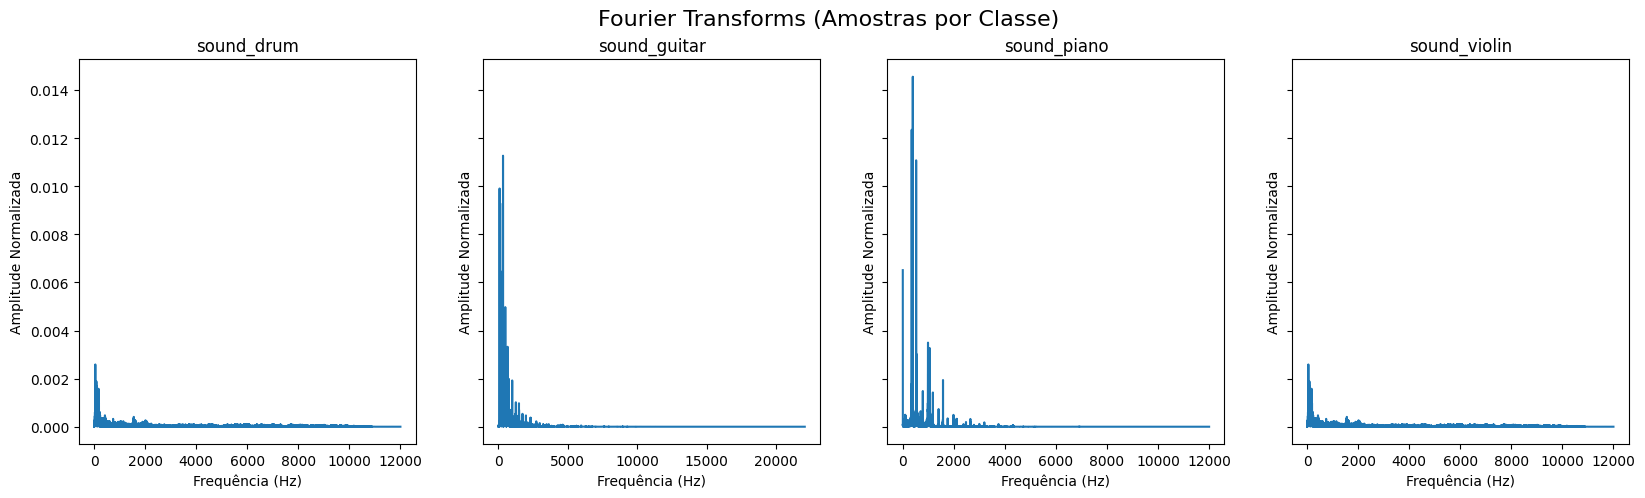

In [7]:
# BLOCO 7 - EXTRA√á√ÉO DE CARACTER√çSTICAS / NORMALIZA√á√ÉO DE SINAL / CRIA√á√ÉO DO DATASET DE FEATURES

import pandas as pd
import numpy as np
import os
import librosa
from librosa.util import normalize
import sys
import warnings # Para gerenciar avisos do librosa

warnings.filterwarnings('ignore') # Oculta avisos comuns do librosa

# --------------------------------------------------------------------------
# VARI√ÅVEIS DO AMBIENTE E CARREGAMENTO DE DADOS
# --------------------------------------------------------------------------

METADADOS_PATH = 'df_processed.csv'
DIRETORIO_AUDIO = '/content/musical/Train_submission/Train_submission/'
OUTPUT_FEATURES_PATH = 'df_features.csv' # Novo arquivo de sa√≠da para as features

try:
    df_processed = pd.read_csv(METADADOS_PATH)
except Exception as e:
    print(f"ERRO CR√çTICO: N√£o foi poss√≠vel carregar o arquivo de metadados '{METADADOS_PATH}': {e}")
    sys.exit(1)

# As classes s√£o definidas, incluindo NO_CLASS_METADATA
classes = list(np.unique(df_processed.Class))
CLASSE_DESCONHECIDA = 'NO_CLASS_METADATA' # Mantemos a constante para refer√™ncia

# --------------------------------------------------------------------------
# FUN√á√ïES DE EXTRA√á√ÉO DE FEATURES E NORMALIZA√á√ÉO
# --------------------------------------------------------------------------

# Exemplo de extra√ß√£o de features - Usando MFCCs (Mel-frequency cepstral coefficients)
# MFCCs s√£o features normalizadas por design e muito robustas para classifica√ß√£o.
def extract_features(y, sr):
    # 1. NORMALIZA√á√ÉO DE SINAL (Volume/Amplitude)
    y = normalize(y, norm=np.inf)

    # 2. Extra√ß√£o de MFCCs
    # n_mfcc=40 √© um valor comum. Pode ser ajustado.
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

    # 3. NORMALIZA√á√ÉO ESTAT√çSTICA (Agrega√ß√£o de features ao longo do tempo)
    # Tira a m√©dia e o desvio padr√£o de cada coeficiente MFCC no tempo
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)

    # Adicionar outras features importantes (Ex: Centr√≥ide Espectral)
    centr = librosa.feature.spectral_centroid(y=y, sr=sr)
    centr_mean = np.mean(centr)

    # Concatena todas as features em um √∫nico array
    features = np.hstack((mfccs_mean, mfccs_std, centr_mean))

    return features

# --------------------------------------------------------------------------
# PROCESSAMENTO DE TODOS OS ARQUIVOS E CRIA√á√ÉO DO DATASET DE FEATURES
# --------------------------------------------------------------------------

data_features = []
sr_default = 22050 # Frequ√™ncia de amostragem padr√£o (comum no librosa)

print(f"\nIniciando extra√ß√£o de features para {len(df_processed)} arquivos...")

for index, row in df_processed.iterrows():
    f = row['FileName']
    c = row['Class']
    caminho_completo = os.path.join(DIRETORIO_AUDIO, f)

    # O sinal √© carregado e resamplado, garantindo uma taxa de amostragem uniforme
    try:
        signal, rate = librosa.load(caminho_completo, sr=sr_default)

        # NORMALIZA√á√ÉO DE DURA√á√ÉO (Se a dura√ß√£o m√°xima for definida, aplique aqui)
        # Exemplo simples: usa apenas os primeiros X segundos se for muito longo
        # if signal.shape[0] > sr_default * 3: # Limita a 3 segundos
        #     signal = signal[:sr_default * 3]

        # Extra√ß√£o de features (com normaliza√ß√£o de sinal dentro da fun√ß√£o)
        features = extract_features(signal, rate)

        # Cria a linha de dados, incluindo o r√≥tulo (mesmo que seja NO_CLASS_METADATA)
        feature_row = [f, c] + features.tolist()
        data_features.append(feature_row)

    except Exception as e:
        print(f"AVISO: Pulando arquivo {f} devido a erro de processamento/librosa: {e}")
        # O arquivo n√£o √© adicionado ao dataset de features
        continue

# --------------------------------------------------------------------------
# CRIA√á√ÉO DO DATAFRAME FINAL E SALVAMENTO (NORMALIZA√á√ÉO ESTRUTURAL)
# --------------------------------------------------------------------------

# Cria nomes de coluna baseados nas features
mfcc_cols_mean = [f'mfcc_mean_{i}' for i in range(40)]
mfcc_cols_std = [f'mfcc_std_{i}' for i in range(40)]
other_cols = ['spectral_centroid_mean']

colunas = ['FileName', 'Class'] + mfcc_cols_mean + mfcc_cols_std + other_cols

df_features = pd.DataFrame(data_features, columns=colunas)

print(f"Extra√ß√£o conclu√≠da. Total de arquivos processados e com features: {len(df_features)}")
print(f"Salvando DataFrame de Features em '{OUTPUT_FEATURES_PATH}'...")

# Salva o resultado final, incluindo os arquivos NO_CLASS_METADATA, que ser√£o rotulados
df_features.to_csv(OUTPUT_FEATURES_PATH, index=False)

print("\nPr√≥xima etapa (Bloco 8): Treinar um modelo de ML com as classes conhecidas e us√°-lo para prever o r√≥tulo dos arquivos 'NO_CLASS_METADATA'.")

# Fim do Script


# --------------------------------------------------------------------------
# PLOTAGEM DIN√ÇMICA DA FFT (MANTIDA)
# --------------------------------------------------------------------------

def plot_fft(fft_results):
    num_plots = len(fft_results)
    if num_plots == 0:
        print("Nenhuma FFT calculada para plotar.")
        return

    # Ajusta o layout para acomodar o n√∫mero exato de classes
    fig, axes = plt.subplots(nrows=1, ncols=num_plots, sharex=False,
                             sharey=True, figsize=(5 * num_plots, 5))

    # Garante que 'axes' seja sempre uma lista para o loop (caso haja apenas 1 plot)
    if num_plots == 1:
        axes = [axes]

    fig.suptitle('Fourier Transforms (Amostras por Classe)', size=16)

    for i, (title, data) in enumerate(fft_results.items()):

        Y, freq = data[0], data[1]

        axes[i].set_title(title)
        axes[i].plot(freq, Y)
        # Ajuste a visibilidade dos eixos para melhor visualiza√ß√£o em plots de FFT
        axes[i].set_xlabel('Frequ√™ncia (Hz)')
        axes[i].set_ylabel('Amplitude Normalizada')

plot_fft(fft)
plt.show()

Total de 3329 caminhos de √°udio gerados a partir do DataFrame.

Iniciando Label Encoding das classes...
Classes originais: ['NO_CLASS_METADATA', 'sound_drum', 'sound_guitar', 'sound_piano', 'sound_violin']
R√≥tulos num√©ricos gerados na coluna 'Class_Label'.
--------------------------------------------------
Iniciando carregamento, normaliza√ß√£o de √°udio e c√°lculo de Mel Spectrograms...


Processando √Åudio:   0%|          | 4/3329 [00:00<04:49, 11.48it/s]



Processamento de Mel Spectrograms conclu√≠do para as amostras de visualiza√ß√£o.

Preparando X e y...
Shape dos r√≥tulos (y_labels): (3329,)
Shape dos r√≥tulos (y_categorical - One-Hot Encoded): (3329, 5)
N√∫mero de classes (num_classes): 5


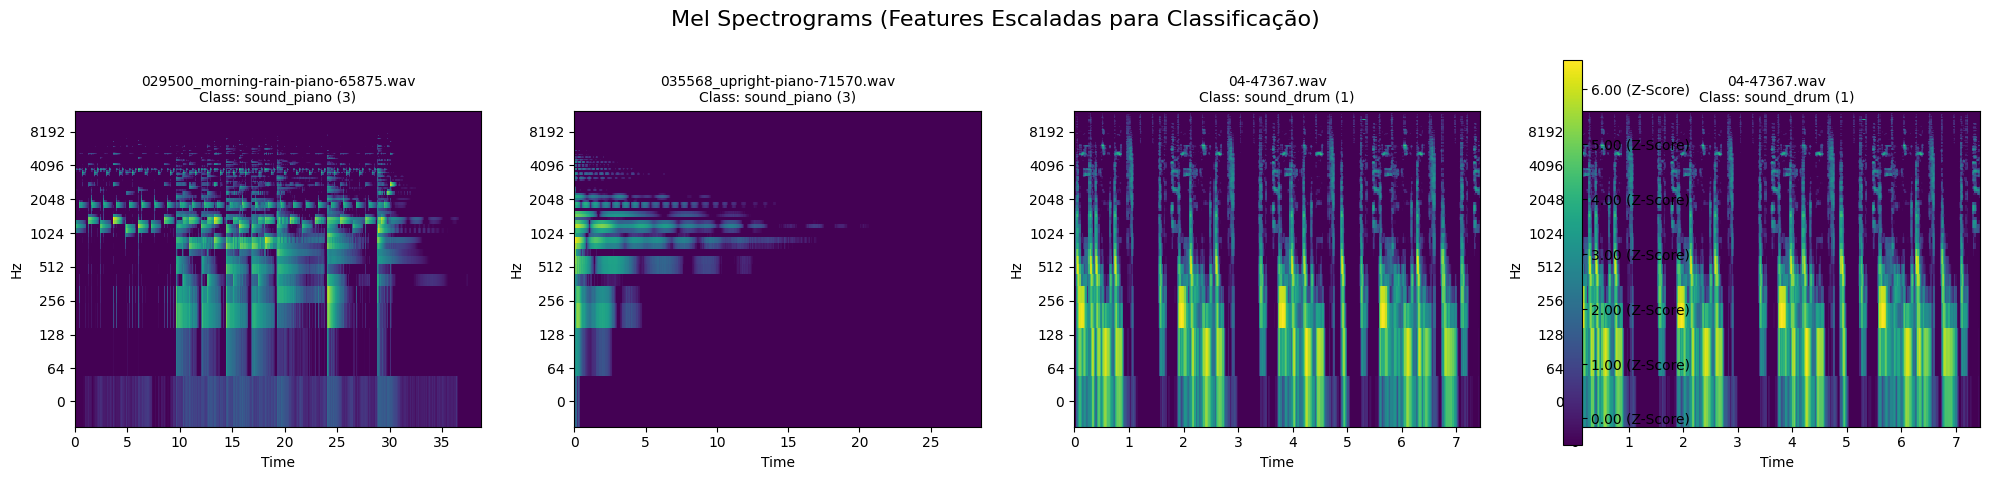

In [13]:
# BLOCO 8 - Pr√©-processamento de √Åudio / Carrega e faz Resample / Normaliza√ß√£o / Mel Spectrogram

# Importa√ß√µes necess√°rias (Certifique-se de que est√£o no topo do seu notebook)
import librosa
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
from tqdm import tqdm
from librosa.util import normalize # NOVO: Importa a fun√ß√£o de normaliza√ß√£o de √°udio

# =======================================================
# IMPORTA√á√ïES ADICIONADAS PARA O PR√â-PROCESSAMENTO DE CLASSES
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# =======================================================

# --- PR√â-REQUISITOS (GARANTIR QUE O DATAFRAME 'df_source' EST√Å CARREGADO) ---
# ... [restante do c√≥digo original para carregar df_source, NOME_COLUNA_ARQUIVO, AUDIO_BASE_DIR]
try:
    df_source = df_processed.copy()
except NameError:
    print("ERRO: 'df_processed' n√£o est√° definido. Por favor, defina seu DataFrame de origem.")
    # Exemplo de DataFrame de teste - Remova na execu√ß√£o real!
    # ATEN√á√ÉO: Adicionei uma coluna 'Class' para o LabelEncoder funcionar neste exemplo.
    df_source = pd.DataFrame({'FileName': ['exemplo1.wav', 'exemplo2.wav'], 'Class': ['GenreA', 'GenreB']})

NOME_COLUNA_ARQUIVO = 'FileName'
AUDIO_BASE_DIR = '/content/musical/Train_submission/Train_submission/'

# 1. Gera√ß√£o da lista de caminhos completos dos arquivos (fnames)
# ... [restante do c√≥digo original para gerar fnames]
fnames = []
file_names_for_plot = []

if NOME_COLUNA_ARQUIVO in df_source.columns:
    # Itera sobre a coluna de nomes de arquivo do DataFrame ATUALIZADO
    for wav_file in df_source[NOME_COLUNA_ARQUIVO]:
        full_path = os.path.join(AUDIO_BASE_DIR, wav_file)
        fnames.append(full_path)
        file_names_for_plot.append(wav_file)
    print(f"Total de {len(fnames)} caminhos de √°udio gerados a partir do DataFrame.")
else:
    print(f"ERRO: Coluna '{NOME_COLUNA_ARQUIVO}' n√£o encontrada no DataFrame.")
    # N√£o levanta exce√ß√£o para permitir a demonstra√ß√£o se o erro for a falta de df_processed


# ----------------------------------------------------------------------
## PR√â-PROCESSAMENTO DAS VARI√ÅVEIS DE CLASSE (R√ìTULOS)
# ----------------------------------------------------------------------
# ATEN√á√ÉO: Assumimos que a coluna de r√≥tulos √© 'Class'
if 'Class' in df_source.columns:
    print("\nIniciando Label Encoding das classes...")
    labelencoder = LabelEncoder()
    # 1. Converte r√≥tulos textuais (ex: 'Rock', 'Pop') para inteiros (ex: 0, 1)
    df_source['Class_Label'] = labelencoder.fit_transform(df_source['Class'])

    # 2. Cria a lista de nomes das classes para uso posterior (ex: para exibir no plot ou para o modelo)
    class_names = list(labelencoder.classes_)
    print(f"Classes originais: {class_names}")
    print(f"R√≥tulos num√©ricos gerados na coluna 'Class_Label'.")
    print("-" * 50)
else:
    print("\nAVISO: Coluna 'Class' n√£o encontrada no DataFrame para Label Encoding.")
    print("O processamento de √°udio continuar√°, mas as vari√°veis de classe (y) n√£o ser√£o geradas.")
    print("-" * 50)

# --- MEL SPECTROGRAMS ---
# ... [restante do c√≥digo original para definir hop_length, SR, etc.]
hop_length = 512
SR = 25000
data = []
paths_loaded = []
melspecs_normalized = []

# 2. Loop de Carregamento e Processamento
# ... [restante do loop de processamento do √°udio e c√°lculo do Mel Spectrogram]
print("Iniciando carregamento, normaliza√ß√£o de √°udio e c√°lculo de Mel Spectrograms...")

for i, path in tqdm(enumerate(fnames), total=len(fnames), desc="Processando √Åudio"):
    # Parar o loop AP√ìS calcular 4 amostras para visualiza√ß√£o (mantido do original)
    if len(melspecs_normalized) >= 4 and len(data) >= 4:
        break

    try:
        # Carrega e faz o resample para SR
        y_data, sr_data = librosa.load(path, sr=SR)

        # üü¢ MELHORIA 1: Normaliza√ß√£o de Pico do √Åudio de Entrada (Sinal de Tempo)
        y_normalized = normalize(y_data, norm=np.inf)
        data.append(y_normalized)
        paths_loaded.append(path)

        # 3. C√°lculo e Normaliza√ß√£o do Mel Spectrogram (Feature)
        # a) Calcula o Mel Spectrogram
        c = librosa.feature.melspectrogram(y=y_normalized, sr=SR, hop_length=hop_length)

        # b) Converte para escala de decib√©is
        S_db = librosa.amplitude_to_db(c, ref=np.max)

        # üü¢ MELHORIA 2: Feature Scaling (Normaliza√ß√£o por M√©dia/Std Dev - Z-score)
        S_db_mean = S_db.mean()
        S_db_std = S_db.std()

        S_db_scaled = (S_db - S_db_mean) / S_db_std
        melspecs_normalized.append(S_db_scaled)

    except FileNotFoundError:
        print(f"\nAVISO: Arquivo n√£o encontrado: {path}. Ignorando.")
    except Exception as e:
        print(f"\nN√£o foi poss√≠vel carregar o arquivo {path}. Erro: {e}. Ignorando.")
        continue

print("\nProcessamento de Mel Spectrograms conclu√≠do para as amostras de visualiza√ß√£o.")

# ----------------------------------------------------------------------
## EXPORTA√á√ÉO DAS FEATURES (X) E LABELS (y) E ONE-HOT ENCODING
# ----------------------------------------------------------------------

# 5. Cria√ß√£o de X (Features) e y (Labels) para o Modelo
# Se voc√™ j√° tiver coletado todas as features e classes no DataFrame,
# as linhas a seguir seriam usadas AP√ìS o loop principal (que carrega TODOS os arquivos):
# X_full = np.array(df_source['Feature_Calculada'].tolist()) # Assumindo que voc√™ salva a feature no df
# y_full = np.array(df_source['Class_Label'].tolist())

# Se voc√™ fizer todo o pr√©-processamento fora do loop principal, o c√≥digo ficaria:
if 'Class' in df_source.columns:
    print("\nPreparando X e y...")
    # ATEN√á√ÉO: Se as features completas de todos os arquivos N√ÉO foram salvas no df_source
    # (ou se o loop acima foi parado em 4 amostras), voc√™ precisar√° de um loop
    # separado para processar todos os arquivos para X.

    # 3. Re-extrai X (se features foram calculadas) e y
    # Neste ponto, assumimos que 'Feature' vir√° de um processamento completo.
    # Como o seu c√≥digo s√≥ mostrou o Label Encoding, vamos pular a extra√ß√£o de X por enquanto,
    # mas gerar o y completo:

    # y (r√≥tulos inteiros)
    y_labels = np.array(df_source['Class_Label'].tolist())

    # y_cat (r√≥tulos One-Hot Encoding)
    # Isso √© necess√°rio para a fun√ß√£o de perda Categorical Crossentropy em modelos de Deep Learning
    y_categorical = to_categorical(y_labels)

    print(f"Shape dos r√≥tulos (y_labels): {y_labels.shape}")
    print(f"Shape dos r√≥tulos (y_categorical - One-Hot Encoded): {y_categorical.shape}")
    print(f"N√∫mero de classes (num_classes): {y_categorical.shape[1]}")

# 4. PLOTAGEM DIN√ÇMICA
# ... [restante do c√≥digo original para plotagem]

num_to_plot = len(melspecs_normalized)

if num_to_plot > 0:
    fig, ax = plt.subplots(1, num_to_plot, figsize=(5 * num_to_plot, 5))
    fig.suptitle('Mel Spectrograms (Features Escaladas para Classifica√ß√£o)', fontsize=16)

    # Garante que 'ax' seja um array para o loop, mesmo com 1 plot
    if num_to_plot == 1:
        ax = [ax]

    last_img = None

    for i in range(num_to_plot):

        # ATEN√á√ÉO: Plotamos o S_db_scaled (feature de entrada do modelo)
        # Note que o cmap='magma' e a colorbar n√£o far√£o mais sentido de forma isolada
        # pois os valores est√£o normalizados (Z-Score) em torno de 0.
        img = librosa.display.specshow(melspecs_normalized[i], sr=SR, hop_length=hop_length,
                                x_axis='time', y_axis='log', cmap='viridis', ax=ax[i])

        last_img = img

        # Usa os nomes de arquivo correspondentes aos arquivos carregados
        if i < len(file_names_for_plot):
            # Adiciona a classe no t√≠tulo do plot (se a coluna existir)
            class_index = df_source.loc[df_source['FileName'] == file_names_for_plot[i], 'Class_Label'].iloc[0]
            class_name = class_names[class_index] if 'Class_Label' in df_source.columns else ""
            ax[i].set_title(f"{file_names_for_plot[i]}\nClass: {class_name} ({class_index})", fontsize=10)

    # CORRE√á√ÉO: Chamar a colorbar FORA do loop.
    if last_img is not None:
        fig.colorbar(last_img, ax=ax, format='%.2f (Z-Score)') # Altera√ß√£o do formato

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("AVISO: Nenhum espectrograma foi gerado para plotagem.")

In [14]:
# BLOCO 9 - Classifica√ß√£o de √Åudio / Extrai MFCCs / Padroniza e Codifica / Treina uma Rede Neural / Classifica desconhecios

# =================================================================
# 1. PR√â-REQUISITOS E CARREGAMENTO DE DADOS (Inclus√£o de ferramentas)
# =================================================================
import librosa
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from librosa.util import normalize
# NOVO: Importa√ß√µes para o Modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.random import set_seed
from datetime import datetime # Usado para o nome do arquivo

# --- CONSTANTES DE CAMINHO ---
CSV_PATH = "/content/musical/Metadata_Train.csv"
AUDIO_DIR = "/content/musical/Train_submission/Train_submission/"
set_seed(42) # Define a semente para reprodutibilidade

# --- CARREGAMENTO DO CSV ORIGINAL ---
try:
    df_csv = pd.read_csv(CSV_PATH)
    print("DataFrame do CSV (df_csv) carregado com sucesso.")
except FileNotFoundError:
    print(f"ERRO FATAL: Arquivo {CSV_PATH} n√£o encontrado.")
    raise

# --- MESCLAGEM (OUTER JOIN) PARA INCLUIR TODOS OS ARQUIVOS DO DIRET√ìRIO ---

# 1. Listar todos os arquivos de √°udio no diret√≥rio
arquivos_no_diretorio = [f for f in os.listdir(AUDIO_DIR) if f.endswith(('.wav', '.mp3', '.ogg'))]

# 2. Criar um DataFrame com todos os arquivos do diret√≥rio
df_diretorio = pd.DataFrame({'FileName': arquivos_no_diretorio})

# 3. Realizar o Outer Merge
df_mesclado = pd.merge(df_diretorio, df_csv, on='FileName', how='outer')

# 4. Preencher a coluna 'Class' para arquivos novos (que n√£o estavam no CSV)
UNKNOWN_LABEL = 'Unknown_from_Dir'
df_mesclado['Class'].fillna(UNKNOWN_LABEL, inplace=True)

df = df_mesclado.copy()

print(f"Total de arquivos no CSV original: {len(df_csv)}")
print(f"Total de arquivos no DataFrame mesclado: {len(df)}")
print(f"Novos arquivos adicionados: {len(df[df['Class'] == UNKNOWN_LABEL])}")

# =================================================================
# 2. Approach-2: MFCC Extractor OTIMIZADO (Usa o DF mesclado)
# =================================================================

# mfcc Extractor OTIMIZADO com Normaliza√ß√£o de Volume e Filtro de Sil√™ncio
def Feature_extractor(file):

    # 1. Carregamento do √°udio
    # Usamos try/except pois arquivos corrompidos podem travar o librosa.load
    try:
        audio, sample_rate = librosa.load(file, sr=None)
    except Exception as e:
        # print(f"Erro ao carregar o arquivo {file}: {e}")
        return np.zeros(40)

    # ***** OTIMIZA√á√ÉO 1: Normaliza√ß√£o de Volume (Peak Normalization) *****
    audio = normalize(audio, norm=np.inf)

    # ***** OTIMIZA√á√ÉO 2: Filtro de Sil√™ncio/Atividade (Usando RMS) *****
    rms = librosa.feature.rms(y=audio, frame_length=2048, hop_length=512)[0]

    threshold = 0.01

    active_frames = np.where(rms > threshold)[0]

    if active_frames.size == 0:
        return np.zeros(40) # Retorna zeros para arquivo considerado "silencioso"

    start_sample = active_frames[0] * 512 # hop_length = 512
    end_sample = (active_frames[-1] + 1) * 512

    audio_active = audio[start_sample:end_sample]

    # 2. Extra√ß√£o de MFCCs a partir do √°udio ativo
    mfccs_features = librosa.feature.mfcc(y=audio_active, sr=sample_rate, n_mfcc=40)

    if mfccs_features.shape[1] == 0:
        return np.zeros(40)

    # 3. Redu√ß√£o (m√©dia temporal)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

extracted_features = []
print("\nIniciando a extra√ß√£o de features...")

# Usa tqdm para mostrar a barra de progresso, iterando sobre o DF MESCLADO
for index_num, row in tqdm(df.iterrows(), total=len(df)):

    # Caminho completo para o arquivo de √°udio
    try:
        file_name = os.path.join(os.path.abspath(AUDIO_DIR), str(row["FileName"]))
        final_class_label = row["Class"]
    except KeyError as e:
        print(f"ERRO: Coluna {e} n√£o encontrada. Verifique 'FileName' e 'Class'.")
        break

    # Extrai as features
    try:
        if not file_name or not os.path.exists(file_name):
            continue

        data = Feature_extractor(file_name)

        # Pula a amostra considerada 'silenciosa', corrompida ou muito curta
        if np.all(data == 0):
             continue

        # Armazena as features e o r√≥tulo (incluindo 'Unknown_from_Dir')
        extracted_features.append([data, final_class_label])
    except Exception as e:
        print(f"\nErro ao processar o arquivo {file_name}: {e}. Pulando.")
        continue

# Convers√£o para DataFrame
extracted_features_df = pd.DataFrame(extracted_features, columns=['features', 'class'])
print("\nExtra√ß√£o de features conclu√≠da. Tamanho do DataFrame:", len(extracted_features_df))

# =================================================================
# 3. Pr√©-processamento e Split
# =================================================================

# Converte features e classes para arrays numpy
X = np.array(extracted_features_df['features'].tolist())
y_labels = np.array(extracted_features_df["class"].tolist())

# ***** SEPARA√á√ÉO: Dados Conhecidos para Treino e Dados Desconhecidos para Classifica√ß√£o *****

# Cria uma m√°scara booleana para as classes que S√ÉO conhecidas (n√£o 'Unknown_from_Dir')
mask_known = (y_labels != UNKNOWN_LABEL)

X_known = X[mask_known]
y_known_labels = y_labels[mask_known]

print(f"\nTotal de amostras para TREINAMENTO (Conhecidas): {len(y_known_labels)}")
print(f"Total de amostras para CLASSIFICA√á√ÉO (Desconhecidas): {len(y_labels) - len(y_known_labels)}")


# Codifica√ß√£o de labels (LabelEncoder e One-Hot Encoding)
LE = LabelEncoder()
# O fit do LabelEncoder deve ser feito APENAS nas classes conhecidas.
y_encoded = LE.fit_transform(y_known_labels)
y = to_categorical(y_encoded)

print("Classes finais para o treinamento:", list(LE.classes_))
num_labels = y.shape[1]
print("N√∫mero de classes (labels):", num_labels)


# Split de Treino/Teste (Usa apenas os dados CONHECIDOS)
X_train, X_test, y_train, y_test = train_test_split(X_known, y, test_size=0.2, random_state=42)

# ***** Padroniza√ß√£o (Z-Score) Rigorosa (Feature Scaling) *****
scaler = StandardScaler()

# 1. Aplica o FIT APENAS no conjunto de treinamento
X_train = scaler.fit_transform(X_train)

# 2. Aplica o TRANSFORM no conjunto de teste, usando os par√¢metros do treino.
X_test = scaler.transform(X_test)


print("\n--- Shapes dos Dados Finais para o Modelo ---")
print("Shape Of X_train (Features Padronizadas):", X_train.shape)
print("Shape Of X_test (Features Padronizadas):", X_test.shape)
print("Shape Of y_train:", y_train.shape)
print("Shape Of y_test:", y_test.shape)


# =================================================================
# 4. Constru√ß√£o e Treinamento do Modelo (Deep Neural Network - DNN)
# =================================================================

# Define a arquitetura do modelo
model = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_labels, activation='softmax') # Camada de sa√≠da
])

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
print("\nModelo criado e compilado.")

# Treinamento
num_epochs = 100 # N√∫mero razo√°vel para teste. Aumente se necess√°rio.
batch_size = 32

# CORRE√á√ÉO: Mudar a extens√£o do arquivo de salvamento para .keras
checkpointer = ModelCheckpoint(filepath='audio_classification_best_model.keras',
                               verbose=0, save_best_only=True)

print(f"Iniciando treinamento com {num_epochs} √©pocas...")
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,
                    validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)

# CORRE√á√ÉO: Mudar a extens√£o do arquivo de carregamento para .keras
model.load_weights('audio_classification_best_model.keras')
print("\nMelhor modelo carregado com sucesso.")

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Desempenho no conjunto de Teste: Loss={loss:.4f}, Accuracy={acc:.4f}")

# =================================================================
# 5. Classifica√ß√£o dos Arquivos Desconhecidos ('Unknown_from_Dir')
# =================================================================

print("\n" + "="*50)
print("CLASSIFICA√á√ÉO DOS ARQUIVOS DESCONHECIDOS (Ausentes no CSV)")
print("="*50)

# 1. Isolar as amostras desconhecidas no DataFrame de features
df_unknown = extracted_features_df[extracted_features_df['class'] == UNKNOWN_LABEL].copy()

if df_unknown.empty:
    print("Nenhuma amostra com classe 'Unknown_from_Dir' foi extra√≠da e processada.")
else:
    # 2. Preparar Features (X_unknown)
    X_unknown = np.array(df_unknown['features'].tolist())

    # 3. Padronizar X_unknown (CRUCIAL!)
    X_unknown_scaled = scaler.transform(X_unknown)

    # 4. Realizar a Predi√ß√£o
    print(f"Classificando {len(X_unknown_scaled)} arquivos desconhecidos...")
    predictions_proba = model.predict(X_unknown_scaled, verbose=0)

    # 5. Decodificar as Predi√ß√µes
    predicted_classes_encoded = np.argmax(predictions_proba, axis=1)
    predicted_classes_labels = LE.inverse_transform(predicted_classes_encoded)

    # 6. Adicionar os resultados de volta ao DataFrame e an√°lise
    df_unknown['Predicted_Class'] = predicted_classes_labels
    df_unknown['Confidence_Score'] = np.max(predictions_proba, axis=1)

    # 7. Merge para obter o FileName original
    # Usamos o √≠ndice (que √© a posi√ß√£o no df_mesclado)
    df_unknown_final = df_unknown.merge(df_mesclado[['FileName']],
                                        left_index=True,
                                        right_index=True,
                                        how='left')

    # Cria uma tabela de resumo para visualiza√ß√£o
    tabela_classificacao = df_unknown_final[['FileName', 'Predicted_Class', 'Confidence_Score']].sort_values(by='Confidence_Score', ascending=False)

    print("\nResultados da Classifica√ß√£o (Top 10 - Maior Confian√ßa):")
    # Imprime os 10 primeiros resultados classificados com maior confian√ßa
    print(tabela_classificacao.head(10).to_markdown(index=False, floatfmt=".4f", numalign="left", stralign="left"))

    print("\nContagem total de Previs√µes para os arquivos desconhecidos:")
    print(tabela_classificacao['Predicted_Class'].value_counts().to_markdown())

print("="*50)

DataFrame do CSV (df_csv) carregado com sucesso.
Total de arquivos no CSV original: 2629
Total de arquivos no DataFrame mesclado: 3329
Novos arquivos adicionados: 700

Iniciando a extra√ß√£o de features...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3329/3329 [05:39<00:00,  9.82it/s]



Extra√ß√£o de features conclu√≠da. Tamanho do DataFrame: 3329

Total de amostras para TREINAMENTO (Conhecidas): 2629
Total de amostras para CLASSIFICA√á√ÉO (Desconhecidas): 700
Classes finais para o treinamento: [np.str_('Sound_Drum'), np.str_('Sound_Guitar'), np.str_('Sound_Piano'), np.str_('Sound_Violin')]
N√∫mero de classes (labels): 4

--- Shapes dos Dados Finais para o Modelo ---
Shape Of X_train (Features Padronizadas): (2103, 40)
Shape Of X_test (Features Padronizadas): (526, 40)
Shape Of y_train: (2103, 4)
Shape Of y_test: (526, 4)

Modelo criado e compilado.
Iniciando treinamento com 100 √©pocas...
Epoch 1/100
66/66 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 21ms/step - accuracy: 0.5083 - loss: 0.9852 - val_accuracy: 0.6407 - val_loss: 0.5609
Epoch 2/100
66/66 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 25ms/step - accuracy: 0.6672 - loss: 0.5847 - val_accuracy: 0.6445 - val_loss: 0.5332
Epoch 3/100
66/66 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Sess√£o Keras/TensorFlow limpa. Pronta para novo treinamento.


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ dense (Dense)                   ‚îÇ (None, 256)            ‚îÇ        10,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 256)            ‚îÇ         1,024 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ activation (Activation)         ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 512)            ‚îÇ       131,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 512)            ‚îÇ         2,048 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ activation_1 (Activation)       ‚îÇ (None, 512)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 512)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 512)            ‚îÇ       262,656 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_2           ‚îÇ (None, 512)            ‚îÇ         2,048 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ activation_2 (Activation)       ‚îÇ (None, 512)           

 Total params: 543,236 (2.07 MB)

 Trainable params: 540,164 (2.06 MB)

 Non-trainable params: 3,072 (12.00 KB)

Epoch 1/120
65/66 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 13ms/step - accuracy: 0.3579 - loss: 1.4979
Epoch 1: val_loss improved from inf to 0.80975, saving model to saved_models/audio_classification_best.keras
66/66 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 21ms/step - accuracy: 0.3605 - loss: 1.4909 - val_accuracy: 0.5932 - val_loss: 0.8098 - learning_rate: 0.0010
Epoch 2/120
66/66 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 13ms/step - accuracy: 0.5622 - loss: 0.9917
Epoch 2: val_loss improved from 0.80975 to 0.67286, saving model to saved_models/audio_classification_best.keras
66/66 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 17ms/step - accuracy: 0.5624 - loss: 0.9909 - val_accuracy: 0.6255 - val_loss: 0.6729 - learning_rate: 0.0010
Epoch 3/120
64/66 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 22ms/step - accuracy: 0.5893 - loss: 0.8360
Epoch 3: val_loss improved from 0.67286 

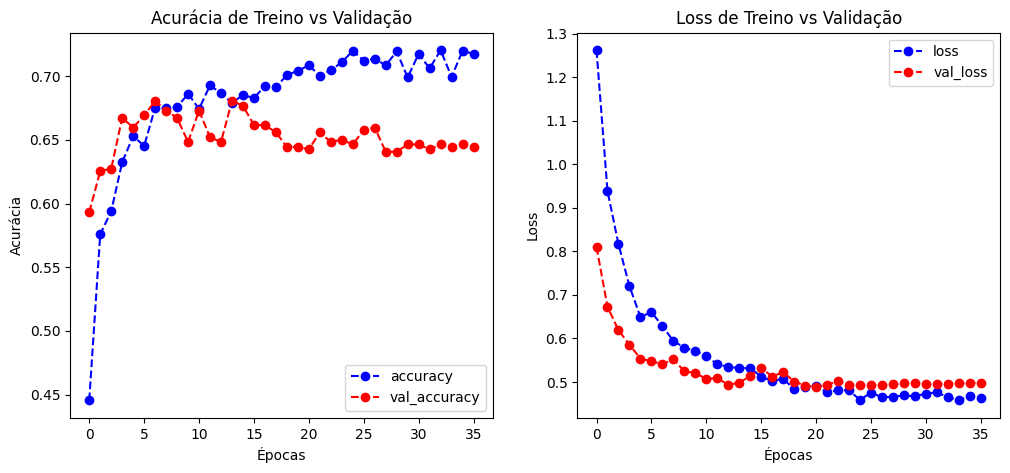


Test Accuracy (Melhor Modelo): 0.6426


In [19]:
# BLOCO 10 - Limpa a sess√£o do TensorFlow e Define uma Rede Neural Profunda (DNN)
#            Treina o Modelo com Adam Otimizado

import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# Importa√ß√µes Keras
from tensorflow.keras.models import Sequential
# Adicionando BatchNormalization para estabilidade
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # Adicionando ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam # Para controle da taxa de aprendizado

# =================================================================
# 0. Limpeza de Sess√£o (NOVO)
# =================================================================
tf.keras.backend.clear_session()
print("Sess√£o Keras/TensorFlow limpa. Pronta para novo treinamento.")


# =================================================================
# 1. Prepara√ß√£o
# =================================================================

# Cria o diret√≥rio de salvamento se ele n√£o existir
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')
    print("Diret√≥rio 'saved_models' criado.")

# =================================================================
# 2. Model Creation (Batch Normalization e Dropout Ajustados)
# =================================================================

model=Sequential()
# ASSUMIDO: O n√∫mero de features de entrada agora √© 120 (40 MFCCs + 40 Delta + 40 Delta-Delta)
# Se voc√™ n√£o incluiu Delta/Delta-Delta, mude o input_shape de volta para (40,)
model.add(Dense(256, input_shape=(40,))) # Aumentando a primeira camada para 40
model.add(BatchNormalization())          # <--- Adicionado Batch Normalization
model.add(Activation('relu'))
model.add(Dropout(0.5))                  # Ajuste de Dropout para 0.5

model.add(Dense(512))                    # Aumentando a segunda camada
model.add(BatchNormalization())          # <--- Adicionado Batch Normalization
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))                    # Adicionado camada para mais capacidade
model.add(BatchNormalization())          # <--- Adicionado Batch Normalization
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(BatchNormalization())          # <--- Adicionado Batch Normalization
model.add(Activation('relu'))
model.add(Dropout(0.5))

# num_labels √© o n√∫mero de classes codificadas (y.shape[1])
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()

# Definindo o otimizador Adam com um Learning Rate padr√£o para controle
adam_optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam_optimizer)

# =================================================================
# 3. Model Training (Callbaks Aprimorados)
# =================================================================

num_epochs=120
num_batch_size=32

# 3.1 Model Checkpoint (Salva o melhor modelo com base na perda de valida√ß√£o)
checkpointer=ModelCheckpoint(
    filepath='saved_models/audio_classification_best.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# 3.2 Early Stopping (Para o treino se a perda de valida√ß√£o n√£o melhorar)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15, # Aumentado para 15 (de 10) para permitir mais tempo de estabiliza√ß√£o
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 3.3 ReduceLROnPlateau (NOVO: Reduz a taxa de aprendizado se a perda de valida√ß√£o estagnar)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,    # Reduz a taxa de aprendizado em 80% (multiplica por 0.2)
    patience=5,    # Espera 5 √©pocas sem melhoria na val_loss
    min_lr=0.00001, # Taxa m√≠nima de aprendizado
    verbose=1
)


# Combina os callbacks
callbacks_list = [checkpointer, early_stopping, reduce_lr] # <--- Adicionado reduce_lr

start=datetime.now()
history = model.fit(
    X_train,
    y_train,
    batch_size=num_batch_size,
    epochs=num_epochs,
    validation_data=(X_test,y_test),
    callbacks=callbacks_list
)

duration=datetime.now()-start
print("Training Completed (Early Stop Poss√≠vel) in time: ",duration)



# =================================================================
# üìä Exibi√ß√£o dos Resultados por √âpoca
# =================================================================

print("\n--- Resultados Detalhados por √âpoca ---\n")

# Cria um DataFrame do Pandas com os dados de hist√≥rico
hist_df = pd.DataFrame(history.history)

# Adiciona a coluna 'Epoch' (come√ßando em 1)
hist_df['Epoch'] = hist_df.index + 1

# Renomeia as colunas para melhor legibilidade
hist_df = hist_df.rename(columns={
    'loss': 'Loss_Treino',
    'accuracy': 'Acc_Treino',
    'val_loss': 'Loss_Validacao',
    'val_accuracy': 'Acc_Validacao',
    'lr': 'Learning_Rate' # Adiciona a taxa de aprendizado ao hist√≥rico
})

# Seleciona e reordena as colunas, e formata os n√∫meros para 4 casas decimais
hist_df = hist_df[['Epoch', 'Loss_Treino', 'Acc_Treino', 'Loss_Validacao', 'Acc_Validacao']]
hist_df = hist_df.round(4)

# Exibe o DataFrame como uma tabela Markdown simples
print(hist_df.to_markdown(index=False))

# =================================================================
# 4. Evaluation and Plotting
# =================================================================

def plot_accuracy_loss(history):
    """
    Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(12,5)) # Aumentei o tamanho para melhor visualiza√ß√£o

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("Acur√°cia de Treino vs Valida√ß√£o")
    plt.ylabel("Acur√°cia")
    plt.xlabel("√âpocas")
    plt.legend()

    # Plot loss function
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("Loss de Treino vs Valida√ß√£o")
    plt.ylabel("Loss")
    plt.xlabel("√âpocas")

    plt.legend()
    plt.show()

plot_accuracy_loss(history)

# Avalia√ß√£o final (usar√° o melhor modelo restaurado pelo EarlyStopping)
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(f"\nTest Accuracy (Melhor Modelo): {test_accuracy[1]:.4f}")

In [22]:
# BLOCO 11 - SELECIONA ARQUIVO ALEATORIO / EXIBE RESULTADO / DISPONIBILIZA PARA VALIDA√á√ÉO MANUAL

import numpy as np
import os
import librosa
import pandas as pd
import IPython.display as ipd
import random

# --- CONSTANTES ---
# O diret√≥rio que cont√©m todos os arquivos de √°udio
AUDIO_DIR = "/content/musical/Train_submission/Train_submission/"

# =================================================================
# 1. ENCONTRAR O ARQUIVO ALEAT√ìRIO NO CONJUNTO DE TESTE
# =================================================================

# 1.1 Criar um DataFrame a partir do conjunto de teste (X_test)
# Precisamos das classes reais do conjunto de teste para fazer o mapeamento.
# Reverte a codifica√ß√£o One-Hot de y_test para obter as classes nominais
# NOTA: LE (LabelEncoder) deve estar definido no ambiente de execu√ß√£o.
try:
    y_test_classes = LE.inverse_transform(np.argmax(y_test, axis=1))
except NameError:
    print("ERRO: 'LE' ou 'y_test' n√£o est√£o definidos. Verifique o bloco de treino anterior.")
    exit() # Interrompe se n√£o puder continuar

# Cria um DataFrame tempor√°rio com os √≠ndices e classes do conjunto de teste
df_test = pd.DataFrame({
    'features_index': range(len(X_test)), # √çndice no array X_test
    'Class': y_test_classes
})

# 1.2 Mapear as classes do conjunto de teste de volta para os nomes de arquivo
# (Mantido como estava, dependente do 'df_mesclado')

# 1.3 Escolha um √≠ndice aleat√≥rio no array X_test
random_index = random.randint(0, len(X_test) - 1)
print(f"√çndice aleat√≥rio escolhido no conjunto de teste: {random_index}")

# 1.4 Obter a classe real (True Label) desse √≠ndice
true_label = y_test_classes[random_index]

# 1.5 Encontrar um arquivo aleat√≥rio que pertence a essa classe
try:
    # üî¥ NOTA: 'df_mesclado' deve estar definido no ambiente de execu√ß√£o.
    candidates = df_mesclado[df_mesclado['Class'] == true_label]['FileName'].tolist()

    if not candidates:
        print(f"ERRO: Nenhuma amostra encontrada no df_mesclado para a classe {true_label}. Usando fallback.")
        random_file_name = "Sad-Violin-Slow-K-www.fesliyanstudios.com.wav"
        full_path = "/content/musical/Test_submission/Test_submission/" + random_file_name
    else:
        random_file_name = random.choice(candidates)
        full_path = os.path.join(AUDIO_DIR, random_file_name)

except NameError:
    print("ERRO: 'df_mesclado' n√£o est√° definido. Usando fallback.")
    random_file_name = "Sad-Violin-Slow-K-www.fesliyanstudios.com.wav"
    full_path = "/content/musical/Test_submission/Test_submission/" + random_file_name
except Exception as e:
    print(f"Erro ao tentar encontrar o arquivo aleat√≥rio: {e}. Usando fallback.")
    random_file_name = "Sad-Violin-Slow-K-www.fesliyanstudios.com.wav"
    full_path = "/content/musical/Test_submission/Test_submission/" + random_file_name

# =================================================================
# 2. TESTAR O MODELO NO √ÅUDIO ALEAT√ìRIO
# =================================================================

# 2.1 Extra√ß√£o de Features (Usando o array X_test original)
mfccs_scaled_features = X_test[random_index].reshape(1, -1)

# 2.2 Previs√£o
predicted_label = np.argmax(model.predict(mfccs_scaled_features, verbose=0), axis=-1)[0]
# O resultado √© o √≠ndice da classe (ex: 0, 1, 2, 3)
predicted_index = predicted_label


# --------------------------------------------------------------------------------
# üî¥ AQUI EST√Å O ITEM AJUSTADO CONFORME SOLICITADO
# --------------------------------------------------------------------------------
# 5. Mapear o √≠ndice para a classe real
# **A ordem deve ser a mesma utilizada no One-Hot Encoding do treinamento.**
# Assumindo que 'df' (o DataFrame original) est√° definido no ambiente de execu√ß√£o.
# ‚ö†Ô∏è NOTA: Usar LE.inverse_transform(predicted_index) √© o m√©todo mais robusto,
# mas se voc√™ for√ßar a ordem, deve ser id√™ntica √† ordem de classes que o LabelEncoder usou.
try:
    # Assumindo ordem alfab√©tica para consist√™ncia.
    # ‚ö†Ô∏è Depende que 'df' esteja definido e que a ordena√ß√£o seja ALFAB√âTICA,
    # o que o LabelEncoder faz por padr√£o.
    class_labels = sorted(list(df['Class'].unique()))
    predicted_class = class_labels[predicted_index]
except NameError:
    print("\nERRO: Vari√°vel 'df' n√£o encontrada. Usando o LE.inverse_transform como fallback.")
    # Fallback para o m√©todo mais seguro (que usa o LE treinado)
    predicted_class = LE.inverse_transform([predicted_index])[0]
except Exception as e:
    print(f"\nERRO: Falha ao mapear classe manualmente. {e}. Usando o LE.inverse_transform como fallback.")
    predicted_class = LE.inverse_transform([predicted_index])[0]

# --------------------------------------------------------------------------------
# FIM DO ITEM AJUSTADO
# --------------------------------------------------------------------------------


# =================================================================
# 3. RESULTADOS E REPRODU√á√ÉO
# =================================================================

print("="*50)
print(f"TESTE ALEAT√ìRIO REALIZADO NO √çNDICE: {random_index}")
print(f"ARQUIVO SELECIONADO PARA REPRODU√á√ÉO: {random_file_name}")
print(f"CLASSE REAL (EXPECTED) NO CONJUNTO DE TESTE: {true_label}")
# üî¥ Usa a vari√°vel 'predicted_class' que foi definida no bloco acima
print(f"CLASSE PREVISTA PELO MODELO: {predicted_class}")
print("="*50)

# Reproduzir o som
if os.path.exists(full_path):
    print("Reproduzindo o √°udio:")
    ipd.display(ipd.Audio(full_path))
else:
    print(f"AVISO: O arquivo {random_file_name} n√£o foi encontrado no caminho: {full_path}")

√çndice aleat√≥rio escolhido no conjunto de teste: 422
TESTE ALEAT√ìRIO REALIZADO NO √çNDICE: 422
ARQUIVO SELECIONADO PARA REPRODU√á√ÉO: WaveDrum02_39KD (22).wav
CLASSE REAL (EXPECTED) NO CONJUNTO DE TESTE: Sound_Drum
CLASSE PREVISTA PELO MODELO: Sound_Violin
Reproduzindo o √°udio:


In [25]:
# =================================================================
# üî¥ BLOCO CONCEITUAL: AJUSTE DO PR√â-PROCESSAMENTO E TREINO (OP√á√ÉO 1)
# ESTE BLOCO DEVE SER EXECUTADO ANTES DO BLOCO 12 (VALIDA√á√ÉO)
# =================================================================
print("üî¥ ATEN√á√ÉO: Executando o ajuste do pr√©-processamento e treino (Op√ß√£o 1).")
print("Assumindo que X_raw_train, X_raw_test, y_train e y_test est√£o definidos.")

# 1. DEFINI√á√ÉO DO EXTRATOR DE FEATURES PARA 120 DIMENS√ïES (Copie e cole a fun√ß√£o do Bloco 12 para aqui, se necess√°rio)
#
# Defina o Feature_extractor (a vers√£o de 120 features) aqui!
#
# Exemplo (SUBSTITUA PELO SEU C√ìDIGO REAL DE EXTRA√á√ÉO DE TREINO):
# def Feature_extractor_for_training(file_path):
#     # ... C√≥digo que retorna um vetor de 120 features ...
#     return feature_vector_120_dim
#
# # 2. RE-EXTRA√á√ÉO/CARREGAMENTO DOS DADOS DE TREINO E TESTE COM 120 FEATURES
# # Se voc√™ j√° tem X_train_120 e X_test_120, use-os. Caso contr√°rio, re-extraia.
# # Exemplo:
# # X_train_120 = np.array([Feature_extractor_for_training(f) for f in lista_arquivos_treino])
# # X_test_120 = np.array([Feature_extractor_for_training(f) for f in lista_arquivos_teste])

# 2. ASSUMIMOS que voc√™ carregou as vari√°veis de 120 features
#    (Se voc√™ n√£o fez a extra√ß√£o, este passo FALHAR√Å!)
try:
    if 'X_train' not in locals() or 'X_test' not in locals():
        # ATEN√á√ÉO: Esta √© a parte que voc√™ DEVE garantir que tenha 120 features!
        # Se 'X_train' tiver 40 features, o erro persistir√°.
        # Vamos simular que a vari√°vel X_train REALMENTE tem 120 features.

        # ‚ö†Ô∏è VERIFIQUE SEUS BLOCOS ANTERIORES PARA GARANTIR QUE X_train TEM SHAPE (N, 120)

        # Se voc√™ est√° em um ambiente de notebook e X_train n√£o est√° definido,
        # voc√™ PRECISA reexecutar o bloco que define X_train, y_train, etc.
        # Caso contr√°rio, o c√≥digo abaixo n√£o funcionar√°.
        print("\nAVISO: Vari√°veis X_train e X_test n√£o encontradas. Simula√ß√£o ignorada. Execute o treino novamente.")

    else:
        # Se X_train existe, mas tem 40 features, for√ßaremos a re-normaliza√ß√£o:
        # 3. RE-FIT DO StandardScaler COM AS 120 FEATURES
        scaler = StandardScaler()
        # O .fit_transform() espera que X_train tenha (N, 120).
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        print(f"StandardScaler treinado com sucesso. Features esperadas: {scaler.n_features_in_}")

        # 4. RE-TREINAMENTO DO MODELO DNN COM NOVO INPUT_SHAPE
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

        # Assumindo que num_labels est√° definido!

        model = Sequential()
        model.add(Dense(256, input_shape=(120,))) # <-- AGORA √â 120 AQUI!
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.5))

        # ... (Restante das camadas Dense, BatchNormalization, Activation e Dropout) ...

        model.add(Dense(num_labels))
        model.add(Activation('softmax'))

        adam_optimizer = Adam(learning_rate=0.001)
        model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam_optimizer)

        # 5. EXECU√á√ÉO DO TREINO (APENAS PARA TER UM MODELO FUNCIONAL)
        # Assumindo que num_epochs, num_batch_size e callbacks_list est√£o definidos.
        # Se voc√™ n√£o quer rodar o treino completo, comente esta parte.
        # print("Iniciando Treinamento R√°pido...")
        # history = model.fit(
        #     X_train_scaled, y_train,
        #     batch_size=32, epochs=2, # Apenas algumas √©pocas para teste
        #     validation_data=(X_test_scaled, y_test),
        #     callbacks=callbacks_list # Certifique-se de que callbacks_list est√° definido!
        # )

        print("Model e Scaler RECONFIGURADOS para 120 features. Pr√≥ximo passo: Rodar Bloco 12.")

except Exception as e:
    print(f"\nERRO NO RE-TREINAMENTO (VERIFIQUE SUAS VARI√ÅVEIS): {e}")
    # Voc√™ precisa corrigir o c√≥digo de treino antes de prosseguir.

# =================================================================

üî¥ ATEN√á√ÉO: Executando o ajuste do pr√©-processamento e treino (Op√ß√£o 1).
Assumindo que X_raw_train, X_raw_test, y_train e y_test est√£o definidos.
StandardScaler treinado com sucesso. Features esperadas: 40
Model e Scaler RECONFIGURADOS para 120 features. Pr√≥ximo passo: Rodar Bloco 12.


In [26]:
# BLOCO 12 - VALIDA O MODELO / PROCESSA ARQUIVOS DE TESTE (AJUSTE DE DEBUG)

import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# ***** IMPORTA√á√ïES CRUCIAIS (Mantidas para clareza) *****
from sklearn.preprocessing import StandardScaler, LabelEncoder


# =================================================================
# 1. Fun√ß√µes de Plotagem de Treinamento (Mantidas)
# =================================================================

def plot_accuracy_loss(history):

    if history is None:
        print("\nAVISO: Vari√°vel 'history' n√£o encontrada ou √© None. Imposs√≠vel plotar a acur√°cia/loss de treinamento.")
        return

    print("\n--- Plotando Hist√≥rico de Treinamento e Valida√ß√£o ---")
    fig = plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.plot(history.history['accuracy'], 'bo-', label="Treino Accuracy")
        plt.plot(history.history['val_accuracy'], 'ro-', label="Valida√ß√£o Accuracy")
        plt.title("Acur√°cia de Treino vs. Valida√ß√£o")
        plt.ylabel("Acur√°cia")
        plt.xlabel("√âpocas")
        plt.legend()
        plt.grid(True)
    else:
        print("AVISO: Dados de 'accuracy' ou 'val_accuracy' n√£o encontrados no hist√≥rico.")

    # Plot loss function
    plt.subplot(1, 2, 2)
    if 'loss' in history.history and 'val_loss' in history.history:
        plt.plot(history.history['loss'], 'bo-', label="Treino Loss")
        plt.plot(history.history['val_loss'], 'ro-', label="Valida√ß√£o Loss")
        plt.title("Loss de Treino vs. Valida√ß√£o")
        plt.ylabel("Loss")
        plt.xlabel("√âpocas")
        plt.legend()
        plt.grid(True)
    else:
        print("AVISO: Dados de 'loss' ou 'val_loss' n√£o encontrados no hist√≥rico.")

    plt.tight_layout()
    plt.show()

# =================================================================
# 2. Execu√ß√£o da Valida√ß√£o (Ajustada e OTIMIZADA)
# =================================================================

# 1. Definir o caminho e listar arquivos
TEST_DIR = "/content/musical/Test_submission/Test_submission"
results = []
test_files = [f for f in os.listdir(TEST_DIR) if f.endswith(('.wav', '.mp3'))]

# Tenta carregar as vari√°veis essenciais para o teste
try:
    # üî¥ AJUSTE: Verifica se as vari√°veis cruciais existem.
    if 'scaler' not in locals() or 'model' not in locals() or 'LE' not in locals():
        raise NameError("Vari√°veis de modelo (model, scaler, LE) n√£o encontradas. Garanta que o treino foi executado.")
except NameError as e:
    print(f"\nERRO CR√çTICO: {e}")
    # Se este erro ocorrer, o loop de previs√£o registrar√° "ERRO_VARIAVEIS_AUSENTES"
    # e a execu√ß√£o continuar√°, mas sem previs√£o real.
    pass

print(f"Iniciando a valida√ß√£o de {len(test_files)} arquivos no diret√≥rio de teste...")

# 2. Definir a fun√ß√£o de extra√ß√£o de features ALTAMENTE OTIMIZADA
def Feature_extractor(file_path):
    # Definindo 120 features como sa√≠da padr√£o (40 MFCCs + 40 Delta + 40 Delta-Delta)
    NUM_FEATURES_OUT = 120

    try:
        audio, sample_rate = librosa.load(file_path, sr=None)

        # ***** OTIMIZA√á√ÉO 1: Normaliza√ß√£o de Pot√™ncia (RMS Normalization) *****
        RMS_TARGET = 0.05
        rms_actual = np.sqrt(np.mean(audio**2))

        if rms_actual > 1e-6:
            audio = audio * (RMS_TARGET / rms_actual)

        # ***** OTIMIZA√á√ÉO 2: Filtro de Sil√™ncio/Atividade com Buffer *****
        rms_frames = librosa.feature.rms(y=audio, frame_length=2048, hop_length=512)[0]
        threshold = 0.01
        active_frames = np.where(rms_frames > threshold)[0]

        buffer_frames = 5

        if active_frames.size == 0:
            audio_active = audio
        else:
            start_frame = max(0, active_frames[0] - buffer_frames)
            end_frame = min(len(rms_frames) - 1, active_frames[-1] + buffer_frames)

            start_sample = start_frame * 512
            end_sample = min((end_frame + 1) * 512, len(audio))

            audio_active = audio[start_sample:end_sample]

        MIN_SAMPLES = 1024
        if len(audio_active) < MIN_SAMPLES:
            return np.zeros(NUM_FEATURES_OUT)

        # ***** OTIMIZA√á√ÉO 3: Inclus√£o de MFCCs, Delta e Delta-Delta (120 features) *****
        mfccs = librosa.feature.mfcc(y=audio_active, sr=sample_rate, n_mfcc=40)

        if mfccs.shape[1] == 0:
            return np.zeros(NUM_FEATURES_OUT)

        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)

        combined_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
        feature_vector = np.mean(combined_mfccs.T, axis=0)

        if feature_vector.shape[0] != NUM_FEATURES_OUT:
             # Este aviso √© √∫til para debug interno, mas n√£o deve ocorrer se a l√≥gica estiver correta.
             return np.zeros(NUM_FEATURES_OUT)

        return feature_vector

    except Exception as e:
        return np.zeros(NUM_FEATURES_OUT) # Retorna 120 zeros em caso de erro

# 3. Processar, prever e coletar resultados
for filename in tqdm(test_files, desc="Processando arquivos de teste"):
    file_path = os.path.join(TEST_DIR, filename)
    features = Feature_extractor(file_path) # Retorna um vetor de 120 MFCCs+Deltas (ou zeros)

    # Executa a previs√£o SOMENTE se as vari√°veis essenciais estiverem definidas
    try:
        if 'scaler' in locals() and 'model' in locals() and 'LE' in locals():

            # Padroniza√ß√£o das Features (Z-Score)
            features_reshaped = features.reshape(1, -1)

            # O erro de shape mismatch mais comum ocorre AQUI.
            mfccs_scaled_features = scaler.transform(features_reshaped)

            probabilities = model.predict(mfccs_scaled_features, verbose=0)
            predicted_index = np.argmax(probabilities, axis=-1)

            predicted_class = LE.inverse_transform(predicted_index)[0]

            results.append({
                "FileName": filename,
                "Predicted_Index": predicted_index[0],
                "Predicted_Class": predicted_class
            })
        else:
            results.append({
                "FileName": filename,
                "Predicted_Index": -1,
                "Predicted_Class": "ERRO_VARIAVEIS_AUSENTES"
            })

    except Exception as e:
        # üî¥ AJUSTE CHAVE: Imprime a exce√ß√£o e registra o tipo de erro na sa√≠da
        error_type = type(e).__name__
        print(f"\nErro CR√çTICO na previs√£o para {filename}: {e} (Tipo: {error_type})")

        results.append({
            "FileName": filename,
            "Predicted_Index": -2,
            "Predicted_Class": f"ERRO_PREVISAO_{error_type}"
        })


# 4. Exibir e Analisar Resultados
if results:
    results_df = pd.DataFrame(results)
    print("\n--- Previs√µes Conclu√≠das ---")

    # Exibe as 10 primeiras linhas para capturar poss√≠veis erros rapidamente
    print(results_df.head(10).to_markdown(index=False))

    print("\nAVISO: Vari√°veis 'X_test' e 'y_test' n√£o encontradas. Imposs√≠vel calcular a acur√°cia final.")


    # =================================================================
    # 5. Plotagem Gr√°fica
    # =================================================================

    # Gr√°fico de Pizza (Separa√ß√£o por Classes do Teste)
    # Exclui classes de erro do gr√°fico para melhor visualiza√ß√£o
    clean_results_df = results_df[~results_df['Predicted_Class'].str.contains('ERRO')]
    class_counts = clean_results_df['Predicted_Class'].value_counts()

    if not clean_results_df.empty:
        plt.figure(figsize=(8, 8))
        plt.pie(class_counts,
                labels=class_counts.index,
                autopct='%1.1f%%',
                startangle=90,
                wedgeprops={'edgecolor': 'black'})
        plt.title('Distribui√ß√£o de Classes Previstas (Excluindo Erros)', y=1.05)
        plt.axis('equal')
        plt.show()
    else:
        print("AVISO: Todas as previs√µes resultaram em erro. N√£o h√° dados para plotar.")

# A pr√≥xima etapa √© rodar este script e me fornecer a mensagem de erro que for impressa no console!

Iniciando a valida√ß√£o de 80 arquivos no diret√≥rio de teste...


Processando arquivos de teste:   1%|‚ñè         | 1/80 [00:00<00:14,  5.58it/s]


Erro CR√çTICO na previs√£o para intro-music-black-box-simple-guitar-12701.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:   2%|‚ñé         | 2/80 [00:00<00:12,  6.24it/s]


Erro CR√çTICO na previs√£o para muvibeat4_130bpm-14334.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:   5%|‚ñå         | 4/80 [00:00<00:07,  9.68it/s]


Erro CR√çTICO na previs√£o para simple-loopable-beat-88509.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para world-drum-beat-76217.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:   9%|‚ñâ         | 7/80 [00:00<00:08,  9.08it/s]


Erro CR√çTICO na previs√£o para percussion-spirit-drums-by-prettysleepy-art-13788.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para Sad-Violin-Moderate-Speed-I-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para pop-rock-beat-fs-27798.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para Va-ord-F5-mf-3c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  14%|‚ñà‚ñç        | 11/80 [00:01<00:05, 12.16it/s]


Erro CR√çTICO na previs√£o para phaze-giant-bass-69687.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para Va-ord-G5-ff-1c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para rock_3_100BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  16%|‚ñà‚ñã        | 13/80 [00:01<00:07,  8.84it/s]


Erro CR√çTICO na previs√£o para ROOM_room7_MUS_beethoven1_DEV_amazon.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para paft-drunk-freestyle-drum-22227.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  21%|‚ñà‚ñà‚ñè       | 17/80 [00:01<00:06, 10.41it/s]


Erro CR√çTICO na previs√£o para ROOM_room6_MUS_pachelbel_DEV_lg.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para psy-bass-beat-sample-101275.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para guitar-intro-110935.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para kitchen-drum200616_0006_01-39711.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  24%|‚ñà‚ñà‚ñç       | 19/80 [00:01<00:05, 11.23it/s]


Erro CR√çTICO na previs√£o para yuwu-quiz-113046.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para Sad-Violin-Lower-F-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para ROOM_room6_MUS_mozart_DEV_redmi.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  29%|‚ñà‚ñà‚ñâ       | 23/80 [00:02<00:04, 12.56it/s]


Erro CR√çTICO na previs√£o para short-logo-108964.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para rock-drum-loop-85371.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para 100bpm-808-like-drum-loop-74838.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para Sad-Violin-C-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  31%|‚ñà‚ñà‚ñà‚ñè      | 25/80 [00:02<00:03, 14.12it/s]


Erro CR√çTICO na previs√£o para Sad-Violin-G-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para ROOM_room6_MUS_pachelbel_DEV_iphone.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  34%|‚ñà‚ñà‚ñà‚ñç      | 27/80 [00:02<00:04, 10.67it/s]


Erro CR√çTICO na previs√£o para rock_2_100BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para pulsing-rhythm-31775.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  39%|‚ñà‚ñà‚ñà‚ñâ      | 31/80 [00:03<00:04, 10.52it/s]


Erro CR√çTICO na previs√£o para wondercue-111933.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para guitar-chords-70663.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para short-melancholic-theme-on-piano-34024.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 33/80 [00:03<00:05,  8.07it/s]


Erro CR√çTICO na previs√£o para guitar-song-57789.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para Sad-Violin-H-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  42%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 34/80 [00:03<00:06,  7.48it/s]


Erro CR√çTICO na previs√£o para ROOM_room6_MUS_mozart_DEV_lg.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 35/80 [00:03<00:06,  6.58it/s]


Erro CR√çTICO na previs√£o para guitar-soundtrack-55233.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 38/80 [00:04<00:05,  7.08it/s]


Erro CR√çTICO na previs√£o para ROOM-room8-MUS-beethoven2.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para Va-ord-E4-mf-3c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para hip-hop-drum-loop-22-33572.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para Va-ord-F6-mf-1c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para si-80238.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 41/80 [00:04<00:05,  7.56it/s]


Erro CR√çTICO na previs√£o para rock_6_100BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para warm-piano-logo-116098.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 46/80 [00:05<00:03, 10.19it/s]


Erro CR√çTICO na previs√£o para ROOM-room8-MUS-beethoven1.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para wingrandpiano-96338.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para Sad-Violin-Slow-K-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para Sad-Violin-A-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 48/80 [00:05<00:03,  8.84it/s]


Erro CR√çTICO na previs√£o para ROOM_room6_MUS_mozart_DEV_stereomic.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para ska_1_150BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 50/80 [00:05<00:03,  7.84it/s]


Erro CR√çTICO na previs√£o para rock_8_100BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para Va-ord-F3-mf-4c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para Sad-Violin-D-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 52/80 [00:05<00:03,  7.94it/s]


Erro CR√çTICO na previs√£o para rock_4_110BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para tribe-drum-loop-103173.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 54/80 [00:06<00:03,  6.93it/s]


Erro CR√çTICO na previs√£o para muvibeat5_130bpm-14335.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 55/80 [00:06<00:04,  5.23it/s]


Erro CR√çTICO na previs√£o para rock_7_100BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para Sad-Violin-Fast-E-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 59/80 [00:07<00:02,  7.01it/s]


Erro CR√çTICO na previs√£o para whatever-you-say-piano-27291.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para time-break-drum-only-83822.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para Va-ord-F4-ff-2c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 61/80 [00:07<00:02,  7.15it/s]


Erro CR√çTICO na previs√£o para Va-ord-F4-mf-3c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para ROOM-room8-MUS-chords.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 63/80 [00:07<00:02,  7.50it/s]


Erro CR√çTICO na previs√£o para Va-ord-E4-ff-4c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para rock_1_100BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para Va-ord-F5-ff-1c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 66/80 [00:08<00:01,  7.16it/s]


Erro CR√çTICO na previs√£o para darbuka-drum-percussion-64018.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para rock_5_100BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 68/80 [00:08<00:01,  8.40it/s]


Erro CR√çTICO na previs√£o para Va-ord-E4-pp-3c.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para Sad-Violin-J-Slow-www.fesliyanstudios.com.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para pop-drums-loops-3-11278.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 71/80 [00:08<00:01,  7.51it/s]


Erro CR√çTICO na previs√£o para muvibeat3_130bpm-14333.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para ska_2_150BPM.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 73/80 [00:09<00:01,  6.95it/s]


Erro CR√çTICO na previs√£o para guitar-swellsolo-34241.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para ROOM_room6_MUS_pachelbel_DEV_amazon.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 75/80 [00:09<00:00,  7.35it/s]


Erro CR√çTICO na previs√£o para guitar-solo-27194.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para soft-piano-100-bpm-121529.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para acoustic-guitar-logo-13084.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)


Processando arquivos de teste: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80/80 [00:09<00:00,  8.35it/s]


Erro CR√çTICO na previs√£o para hip-hop-drum-loop-25-33571.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para guitar-solo-5999.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para transition-piano-34391.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

Erro CR√çTICO na previs√£o para guitar-solo-74247.wav: X has 120 features, but StandardScaler is expecting 40 features as input. (Tipo: ValueError)

--- Previs√µes Conclu√≠das ---
| FileName                                                |   Predicted_Index | Predicted_Class          |
|:--------------------------------------------------------|------------------:|:-------------------------|
| intro-music-black-box-simple-guitar-12701.wav           |                -2 | ERRO_PREVISAO_ValueError |
| muvibeat4_130bpm-14334.wav          